# 1D RESNET 18 Pyro VAE 

The goal is to find a reduced representation of the 12 leads ECG dataset. We will use a ResNet basis for the encoder and decoder as Resnet 34 proved to be efficient for building a classifier. For memory availability reasons we will stop at Resnet 18 and again at the 3 last seconds of the recording (30 seconds and ResNet 34 for the publication). Below some interesting readings

https://github.com/arnaghosh/Auto-Encoder/blob/master/resnet.py


https://github.com/julianstastny/VAE-ResNet18-PyTorch/blob/master/model.py

**Spoiler alert** : we have a quite good generative (I didn't compare to the lstm) model but the latent space doesn't structure around diseases (eventhough the Resnet 34  is used for classification in the paper, so it should be able to retain this kind of structures) ... unfortunate... Even with all my tries to better represent the data : normalizing flow, Laplace distribution maximum likelihood and KL annealing...

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os

import numpy as np
import torch

import torch.nn as nn

import torch; torch.manual_seed(0)

import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from torch.utils import data
from torch.utils.data import DataLoader
from torch.distributions import constraints

import pandas as pd

import scipy as sc
import seaborn as sns

import scipy.io
import sklearn
import seaborn as sns
import json

In [2]:
import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO
from pyro.optim import AdamW,ClippedAdam

from pyro.distributions import ConditionalTransformedDistribution

from pyro.nn import AutoRegressiveNN
from pyro.distributions.transforms import AffineAutoregressive

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
leads=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [5]:
def making_dico_label(file,list_classes):
    df=pd.read_csv(file)
    
    dico_filename_label={n:torch.LongTensor([0 if u!=l-1 else 1 for u in range(9)]) for n,l in zip(df['Recording'],df['First_label'])}
    dico_label={n:l-1 for n,l in zip(df['Recording'],df['First_label'])}
    dico_label_name={i:l for i,l in enumerate(list_classes)}
    
    return dico_filename_label, dico_label_name,dico_label

In [6]:
dico_filename_label, dico_label_name,dico_label=making_dico_label('',['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE'])

In [7]:
list_file=[i for i in os.listdir('')
           if i.endswith('.mat')]

# Data pre process 

In [8]:
list_to_stratify=[dico_label_name[int(np.argmax(dico_filename_label[i[:-4]]))] for i in list_file ]

In [9]:
from sklearn.model_selection import train_test_split
list_files=[v[:-4] for v in list_file]
X_train_val,X_test,y_train_val,y_test,list_strat_train_val,list_strat_test=train_test_split(list_files,[dico_label[s] for s in list_files],list_to_stratify, stratify=list_to_stratify,random_state=0, test_size=0.1)
X_train,X_val,y_train,y_val=train_test_split(X_train_val,y_train_val,stratify=list_strat_train_val, random_state=0, test_size=0.1)

I stopped at the last 3 seconds (1500 points)

In [10]:
off=int(1500)

Scaling seemed to be important before so let's do it again

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in X_train:
    mat=scipy.io.loadmat(''+i)
    #print(np.array([mat['ECG'][0][0][2].T[-k] for k in range(off)]).shape)
    
    scaler.partial_fit(np.array([mat['ECG'][0][0][2].T[-k] for k in range(min(off,mat['ECG'][0][0][2].shape[1]))]))

In [12]:
from torch.utils.data import Dataset
class ECG_12_leads_VGG_dataset(Dataset):
    def __init__(self,offset,ECGs_names):
        self.ECGs_names=ECGs_names
        self.offset = offset
        
        
    def __len__(self):
        return len(self.ECGs_names)
    
    def __getitem__(self, item):
        ECGs_name=self.ECGs_names[item]
        
        ECG_=scipy.io.loadmat(''+ECGs_name)['ECG'][0][0][2].T
        ECG_ =(ECG_-scaler.mean_)/scaler.scale_
        nsteps, _ = ECG_.shape
        ECG_= ECG_[-self.offset:,:]
        
        ECG=np.zeros((self.offset, ECG_.shape[1]))
        ECG[-nsteps:,:]=ECG_
        
    
        return torch.tensor(ECG.T, dtype=torch.float32)#,classe

In [13]:
train_dataset = ECG_12_leads_VGG_dataset(offset=off,ECGs_names=X_train)

train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,num_workers=16)

val_dataset = ECG_12_leads_VGG_dataset(offset=off,ECGs_names=X_val)

val_data_loader = torch.utils.data.DataLoader(val_dataset,batch_size=64,num_workers=16)

test_dataset = ECG_12_leads_VGG_dataset(offset=off,ECGs_names=X_test)

test_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,num_workers=16)

# Resnet encoder - decoder

In [14]:
class BasicBlock_encoder(nn.Module):
    def __init__(self, in_channels, out_channels,dro,stride=1,downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample
        self.stride = stride
        self.drop = nn.Dropout(p=dro)
        

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)

        return out

In [15]:
class Encoder(nn.Module):

    def __init__(self, block, layers,n_channels_init,dro,latent_space_dim):
        super (Encoder, self).__init__()
        gazing=20992#this is the size of your representation after the ResNEt (you have to calculate it)
        self.wanted_in_channels = 64
        self.latent_space_dim = latent_space_dim
        self.dro = dro
        self.conv1 = nn.Conv1d(n_channels_init, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)#, return_indices = True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool1d(7, stride=1)
        #this is just to get to the latent space dim smoothly
        self.fc2 = nn.Linear(gazing, gazing//25)
        self.fc2_bn = nn.BatchNorm1d(gazing//25)
        self.fc3 = nn.Linear(gazing//25, latent_space_dim)
        self.fc3_sigma = nn.Linear(gazing//25, latent_space_dim)
        

    def _make_layer(self,block,out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.wanted_in_channels != out_channels :
            downsample = nn.Sequential(
                nn.Conv1d(self.wanted_in_channels, out_channels ,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels ),
            )

        layers = []
        layers.append(block(self.wanted_in_channels, out_channels, self.dro,stride, downsample))
        self.wanted_in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.wanted_in_channels, out_channels,self.dro))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        #print the length of the x above to have an idea of the value of the gazing variable
        #print(x.shape)
        x = self.fc2(x)
        x = self.fc2_bn(x)
        x = F.tanh(x)# this turned out to be really important for the layer to not explode into inf
        #producing mean and variance
        x1 = self.fc3(x)
        #x2 = torch.abs(self.fc3_sigma(x)+1e-20)# add to add an epsilon and also couldn't use the torch.exp because value where inf
        x2 = torch.exp(self.fc3_sigma(x))
        return x1,x2

In [16]:
class BasicBlock_decoder(nn.Module):
    def __init__(self, in_channels, out_channels,dro,stride=1,upsample=None):
        super().__init__()
        self.conv1 = nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.ConvTranspose1d(out_channels, out_channels, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.upsample = upsample
        self.stride = stride
        self.drop = nn.Dropout(p=dro)
        

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.upsample is not None:
            identity = self.upsample(x)
        out += identity
        out = self.relu(out)

        return out

In [17]:
class Decoder(nn.Module):
    def __init__(self,block,layers,initial_len,latent_space_dim,dro,initial_channels):
        super(Decoder,self).__init__()
        gazing=20992
        self.wanted_in_channels=512
        self.initial_len = initial_len
        self.dro = dro
        #your Resnet decoder is not going to change the length of your time series
        #so you have to make sure that you feed it something that have 512 channels and kind of the good
        #length : here the good lenth divided by 50
        self.fc = nn.Linear(latent_space_dim,512*initial_len//50)
        #I had to divide by 50 before so now I have to increase the size by 50 for that I am upsampling and 
        #contransposing
        #do the math : it is the only way (not necessarly the 50) so that you latent space can be feed
        #to a decoder ResNet with the right time series length
        self.adjust1 = nn.ConvTranspose1d(512, 512, kernel_size=5,stride=5,bias=False)
        self.bn1 = nn.BatchNorm1d(512)
        self.upsamp1 = nn.Upsample(scale_factor=2,mode='linear')
        self.adjust2 = nn.ConvTranspose1d(512, 512, kernel_size=5,stride=5,bias=False)
        self.bn2 = nn.BatchNorm1d(512)
        
        self.layer1 = self._make_layer(block, 512,layers[0])
        self.layer2 = self._make_layer(block, 256,layers[1])
        self.layer3 = self._make_layer(block, 128,layers[2])
        self.layer4 = self._make_layer(block, 64,layers[3])
        
        
        self.adjust_conv = nn.ConvTranspose1d(64, initial_channels, kernel_size=1,stride=1,bias=False)
        
    def _make_layer(self,block,out_channels, blocks, stride=1):
        upsample = None
        if stride != 1 or self.wanted_in_channels != out_channels :
            upsample = nn.Sequential(
                nn.ConvTranspose1d(self.wanted_in_channels, out_channels ,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels ),
            )

        layers = []
        layers.append(block(self.wanted_in_channels, out_channels, self.dro,stride, upsample))
        self.wanted_in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.wanted_in_channels, out_channels,self.dro))
        return nn.Sequential(*layers)
        
        
    
    def forward(self,x):
        
        x = self.fc(x)
        x = F.relu(x)
        
        x = x.view(x.size(0),512,x.size(1)//(512))
        x = self.adjust1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.upsamp1(x) 
        x = self.adjust2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        x = self.layer1(x)
        
        x = self.layer2(x)
        
        x = self.layer3(x)
        
        x = self.layer4(x)
        
        x = self.adjust_conv(x)
        
        return x

In [18]:
#get access to the value of the gazing variable, we go for a latent space of size 1000
x=torch.FloatTensor(np.random.randn(16,12,off))
model=Encoder(BasicBlock_encoder,[1,1,1,1],12,0.5,1000)
y=model(x)

In [19]:
x.shape

torch.Size([16, 12, 1500])

# Pyro VAE (dimension reduction 90)

In [20]:
from pyro.nn.dense_nn import DenseNN
import pyro.distributions.transforms as T
import pyro.distributions as dist
#from pyro.distributions.conditional import ConditionalTransformedDistribution,ConditionalSpline

lay=[1,1,1,1]*2#ResNet18
class PyroVAE(nn.Module):
    def __init__(self,n_channels_init=12,latent_space_dim=500,initial_len=off,dro=0.5,use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(BasicBlock_encoder, lay,n_channels_init=n_channels_init,dro=dro,latent_space_dim=latent_space_dim)
        self.decoder = Decoder(BasicBlock_decoder, lay[::-1],initial_len=initial_len,latent_space_dim=latent_space_dim,dro=dro,initial_channels=n_channels_init)
        
        self.split_dim=int(latent_space_dim/2)
        
        self.transform = T.conditional_spline_autoregressive(latent_space_dim,12*1500,[500,500,500])
       
        
        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.n_channels_init = n_channels_init
        self.dro = dro
        self.latent_space_dim = latent_space_dim
        self.initial_len = initial_len
        

        
        
        self.dro = dro
        
        
        
    def model(self, x,annealing_factor=1.0):
        
        pyro.module("decoder", self.decoder)
        
       
        with pyro.plate("data", x.shape[0]):
            
            z_loc = x.new_zeros(torch.Size((x.shape[0],self.latent_space_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0],self.latent_space_dim)))
            
            kappa = pyro.param("kappa", torch.tensor([0.75]), constraint=constraints.positive)
            lamb = pyro.param("lamb", torch.tensor([2]), constraint=constraints.positive)
            z_dist = dist.Normal(z_loc, z_scale)
           
            
            with pyro.poutine.scale(None, annealing_factor):#KL annealing can be important when training VAE
                z = pyro.sample("latent", z_dist.to_event(1))
                
            
            loco = self.decoder(z)
            meano = pyro.deterministic('meano',loco.flatten().cpu()+(kappa**2-1)/(lamb*kappa))
            kappa_sq = pyro.deterministic('kappa_sq',kappa**2)
            pyro.sample("obs", dist.AsymmetricLaplace(loc=meano.to(device),scale=lamb.to(device),asymmetry=kappa_sq.to(device)).to_event(1), obs=x.flatten())
            


    
    def guide(self, x,annealing_factor=1.0):
        #pyro.module("iafs", self.iafs)
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            
            z_loc, z_scale = self.encoder(x)
            z_dist = dist.Normal(z_loc, z_scale)
            
            z_dist = dist.ConditionalTransformedDistribution(z_dist.to_event(1), [self.transform])
            
            with pyro.poutine.scale(None, annealing_factor):
                z=pyro.sample("latent", z_dist.condition(x.view(x.shape[0],-1)))
            
    
    

    def reconstruct_ecg(self, x):
        
        z_loc, z_scale = self.encoder(x)
        
        z = dist.Normal(z_loc, z_scale)#.sample()
        
        z = dist.ConditionalTransformedDistribution(z.to_event(1), [self.transform]).condition(x.view(x.shape[0],-1)).sample()
        
        
        loco = self.decoder(z)
        return loco
    
    




In [21]:
def train_pyroVAE_better(svi, model,train_loader,val_loader,epoch,use_cuda=False):
    
    criterion = nn.MSELoss(reduction='mean').to(device)
    epoch_loss = 0.
    
    model = model.train()
    k=epoch
    if k==0:
        annealing_factor=1./(200)
    else:
        annealing_factor=k/(200)
    annealing_factor+=1./(200)
    if annealing_factor>1:
        annealing_factor=1
    #print('annealing factor for KL',annealing_factor)
    for d in train_loader:
        
        x=d
        if use_cuda:
            x = x.cuda()
        
        epoch_loss += svi.step(x,annealing_factor)/x.shape[0]
        
    val_losses = []
    train_losses = []
    #not sure you need any of those eval and torch.no_grad(). Here I just want to have another metric than the elbow, I believe it is more readable.
    model = model.eval()
    with torch.no_grad():
        for d in train_loader:
            seq_true=d
            seq_true = seq_true.to(device)
            seq_pred = model.reconstruct_ecg(seq_true)
           
            
            train_losses.append(criterion(seq_pred, seq_true).item())
        for d in val_loader:
            seq_true=d
            seq_true = seq_true.to(device)
            seq_pred = model.reconstruct_ecg(seq_true)
            
            val_losses.append(criterion(seq_pred, seq_true).item())
    train_loss = np.mean(train_losses)
    
    val_loss = np.mean(val_losses)
    # return epoch loss
    normalizer_train = len(train_loader)
    total_epoch_loss_train = epoch_loss / normalizer_train
    
    return total_epoch_loss_train,train_loss,val_loss

In [22]:
LEARNING_RATE = 1.0e-3
WD = 5*1e-2
USE_CUDA = True

# Run only for a single iteration for testing
NUM_EPOCHS = 500

In [23]:
from pyro.optim import MultiStepLR

In [24]:
pyro.clear_param_store()

# setup the VAE
pyrovae = PyroVAE(n_channels_init=12,latent_space_dim=500,initial_len=off,dro=0.5,use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE,"weight_decay": WD,"clip_norm":1}
#optimizer = AdamW(adam_args)
optimizer = ClippedAdam(adam_args)
#scheduler = MultiStepLR({'optimizer': torch.optim.AdamW,
                             #'optim_args': {'lr': LEARNING_RATE,'weight_decay': WD,},
                             #'milestones': [300],
                             #'gamma': 0.2})

# setup the inference algorithm
svi = SVI(pyrovae.model, pyrovae.guide, optimizer,loss=Trace_ELBO())
#svi = SVI(pyrovae.model, pyrovae.guide, scheduler,loss=Trace_ELBO())

train_elbo = []
val_l1_list = []
train_l1_list = []
pyro.clear_param_store()
# training loop, sorry there might be a bit of miss labelling between L1 and L2 loss
best_i=0
best_l=np.inf
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train,train_l1,val_l1 = train_pyroVAE_better(svi, pyrovae,train_data_loader,val_data_loader,epoch ,use_cuda=USE_CUDA)
    if total_epoch_loss_train<best_l:
        MODEL_PATH = '/AutoregSpline_flow_Asym_Laplace_resnet_18_relu_pyro_vae_500_bn_bis.pth'

        torch.save(pyrovae.state_dict(), MODEL_PATH)
        print(epoch)
        best_l=total_epoch_loss_train
    train_elbo.append(-total_epoch_loss_train)
    train_l1_list.append(train_l1)
    val_l1_list.append(val_l1)
    print("[epoch %03d]  average training ELBO loss: %.4f, average training l2 loss: %.4f average val loss: %.4f" % (epoch, total_epoch_loss_train,train_l1,val_l1))

0
[epoch 000]  average training ELBO loss: 1953276.8003, average training l2 loss: 1.0095 average val loss: 1.4063
1
[epoch 001]  average training ELBO loss: 1773243.1655, average training l2 loss: 0.9904 average val loss: 1.3915
2
[epoch 002]  average training ELBO loss: 1643837.6918, average training l2 loss: 0.9637 average val loss: 1.3678
3
[epoch 003]  average training ELBO loss: 1553316.2968, average training l2 loss: 0.9572 average val loss: 1.3627
4
[epoch 004]  average training ELBO loss: 1479053.5959, average training l2 loss: 0.9508 average val loss: 1.3586
5
[epoch 005]  average training ELBO loss: 1407936.7756, average training l2 loss: 0.9488 average val loss: 1.3560
6
[epoch 006]  average training ELBO loss: 1338987.2067, average training l2 loss: 0.9379 average val loss: 1.3464
7
[epoch 007]  average training ELBO loss: 1270938.0605, average training l2 loss: 0.9237 average val loss: 1.3334
8
[epoch 008]  average training ELBO loss: 1203116.1080, average training l2 los

72
[epoch 072]  average training ELBO loss: 128878.5153, average training l2 loss: 0.3882 average val loss: 0.9663
[epoch 073]  average training ELBO loss: 143490.7007, average training l2 loss: 0.3827 average val loss: 0.9651
74
[epoch 074]  average training ELBO loss: 125062.0534, average training l2 loss: 0.3829 average val loss: 0.9740
75
[epoch 075]  average training ELBO loss: 100759.1321, average training l2 loss: 0.3845 average val loss: 0.9698
[epoch 076]  average training ELBO loss: 112707.1912, average training l2 loss: 0.3755 average val loss: 0.9576
[epoch 077]  average training ELBO loss: 117393.9889, average training l2 loss: 0.3365 average val loss: 0.9192
78
[epoch 078]  average training ELBO loss: 64988.6621, average training l2 loss: 0.3355 average val loss: 0.9119
79
[epoch 079]  average training ELBO loss: 62331.6297, average training l2 loss: 0.3568 average val loss: 0.9340
[epoch 080]  average training ELBO loss: 106799.2434, average training l2 loss: 0.3393 aver

[epoch 145]  average training ELBO loss: -180373.6853, average training l2 loss: 0.2365 average val loss: 0.8536
[epoch 146]  average training ELBO loss: -176344.8521, average training l2 loss: 0.2300 average val loss: 0.8505
[epoch 147]  average training ELBO loss: -189355.6023, average training l2 loss: 0.2272 average val loss: 0.8453
[epoch 148]  average training ELBO loss: -200684.1140, average training l2 loss: 0.2299 average val loss: 0.8379
[epoch 149]  average training ELBO loss: -193898.8358, average training l2 loss: 0.2282 average val loss: 0.8439
[epoch 150]  average training ELBO loss: -193264.2711, average training l2 loss: 0.2109 average val loss: 0.8295
151
[epoch 151]  average training ELBO loss: -211204.8938, average training l2 loss: 0.2081 average val loss: 0.8334
[epoch 152]  average training ELBO loss: -197843.6852, average training l2 loss: 0.2165 average val loss: 0.8410
[epoch 153]  average training ELBO loss: -165248.8990, average training l2 loss: 0.2345 aver

217
[epoch 217]  average training ELBO loss: -334867.1052, average training l2 loss: 0.1781 average val loss: 0.8193
[epoch 218]  average training ELBO loss: -334097.3005, average training l2 loss: 0.1786 average val loss: 0.8183
[epoch 219]  average training ELBO loss: -330850.4208, average training l2 loss: 0.1799 average val loss: 0.8166
220
[epoch 220]  average training ELBO loss: -334905.9840, average training l2 loss: 0.1889 average val loss: 0.8273
[epoch 221]  average training ELBO loss: -329450.7623, average training l2 loss: 0.1946 average val loss: 0.8329
[epoch 222]  average training ELBO loss: -333118.5623, average training l2 loss: 0.1805 average val loss: 0.8211
223
[epoch 223]  average training ELBO loss: -335021.3640, average training l2 loss: 0.1823 average val loss: 0.8161
224
[epoch 224]  average training ELBO loss: -354681.9241, average training l2 loss: 0.1766 average val loss: 0.8161
225
[epoch 225]  average training ELBO loss: -357129.6158, average training l2 l

[epoch 290]  average training ELBO loss: -419352.5874, average training l2 loss: 0.1605 average val loss: 0.8094
291
[epoch 291]  average training ELBO loss: -424379.5689, average training l2 loss: 0.1630 average val loss: 0.8124
[epoch 292]  average training ELBO loss: -418844.6946, average training l2 loss: 0.1669 average val loss: 0.8210
[epoch 293]  average training ELBO loss: -407258.7310, average training l2 loss: 0.1599 average val loss: 0.8120
[epoch 294]  average training ELBO loss: -403631.4989, average training l2 loss: 0.1635 average val loss: 0.8199
[epoch 295]  average training ELBO loss: -398462.9687, average training l2 loss: 0.1662 average val loss: 0.8160
[epoch 296]  average training ELBO loss: -411546.5817, average training l2 loss: 0.1627 average val loss: 0.8142
297
[epoch 297]  average training ELBO loss: -427717.1261, average training l2 loss: 0.1698 average val loss: 0.8250
298
[epoch 298]  average training ELBO loss: -430927.4499, average training l2 loss: 0.1

[epoch 362]  average training ELBO loss: -487113.0868, average training l2 loss: 0.1395 average val loss: 0.7984
[epoch 363]  average training ELBO loss: -498136.0186, average training l2 loss: 0.1367 average val loss: 0.7994
364
[epoch 364]  average training ELBO loss: -528830.7865, average training l2 loss: 0.1374 average val loss: 0.7917
[epoch 365]  average training ELBO loss: -522771.1135, average training l2 loss: 0.1365 average val loss: 0.7944
[epoch 366]  average training ELBO loss: -507176.9541, average training l2 loss: 0.1325 average val loss: 0.7809
[epoch 367]  average training ELBO loss: -509842.4055, average training l2 loss: 0.1352 average val loss: 0.7885
[epoch 368]  average training ELBO loss: -508862.5161, average training l2 loss: 0.1376 average val loss: 0.8043
[epoch 369]  average training ELBO loss: -503588.0708, average training l2 loss: 0.1406 average val loss: 0.8186
[epoch 370]  average training ELBO loss: -504881.1752, average training l2 loss: 0.1360 aver

[epoch 435]  average training ELBO loss: -547254.6864, average training l2 loss: 0.1407 average val loss: 0.8092
[epoch 436]  average training ELBO loss: -537020.5083, average training l2 loss: 0.1419 average val loss: 0.8009
[epoch 437]  average training ELBO loss: -551953.0275, average training l2 loss: 0.1650 average val loss: 0.8085
[epoch 438]  average training ELBO loss: -546908.0707, average training l2 loss: 0.1574 average val loss: 0.8074
[epoch 439]  average training ELBO loss: -521299.7176, average training l2 loss: 0.1411 average val loss: 0.8033
[epoch 440]  average training ELBO loss: -514573.7106, average training l2 loss: 0.1329 average val loss: 0.8033
[epoch 441]  average training ELBO loss: -522407.6621, average training l2 loss: 0.1272 average val loss: 0.7947
[epoch 442]  average training ELBO loss: -544075.5924, average training l2 loss: 0.1269 average val loss: 0.7904
[epoch 443]  average training ELBO loss: -541182.0630, average training l2 loss: 0.1210 average 


MODEL_PATH = '/Asym_Laplace_resnet_18_relu_pyro_vae_1000.pth'

torch.save(pyrovae.state_dict(), MODEL_PATH)

In [25]:
_dataset = ECG_12_leads_VGG_dataset(offset=off,ECGs_names=list_files)

_data_loader = torch.utils.data.DataLoader(_dataset,batch_size=64,num_workers=16)

In [26]:

MODEL_PATH = 'AutoregSpline_flow_Asym_Laplace_resnet_18_relu_pyro_vae_500_bn_bis.pth'
USE_CUDA = True
pyrovae=PyroVAE()
pyrovae.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [29]:
pyrovae.to(device)

PyroVAE(
  (encoder): Encoder(
    (conv1): Conv1d(12, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock_encoder(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout(p=0.5, inplace=False)
      )
    )
    (layer2): Sequential(
      (0): BasicBlock_encoder(
        (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
     

In [27]:
pyro.param('kappa')

tensor([0.9764], grad_fn=<AddBackward0>)

In [28]:
pyro.param('lamb')

tensor([0.1520], grad_fn=<AddBackward0>)

# A few plots

In [31]:
import umap.umap_ as umap
def basic_umap(data,nei,colo):
    data_temp=[]
   
    for d in data:
        
       
        x,_=pyrovae.encoder(d.to(device))
            
        data_temp.append(x.detach().cpu().numpy())
    X=np.vstack(data_temp)
    umaper = umap.UMAP(n_components=2,n_neighbors=nei)
    umaper.fit(X)
    x_umap = umaper.transform(X)
    sc=plt.scatter(x_umap[:, 0], x_umap[:, 1],s=2, c=colo, cmap='Paired')
    cb = plt.colorbar(sc,ticks=np.arange(0,9,1))
    cb.ax.tick_params(labelsize=9)
    #cb.ax.set_yticklabels([])
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('UMAP latent space')
    plt.show()
    return umaper, X

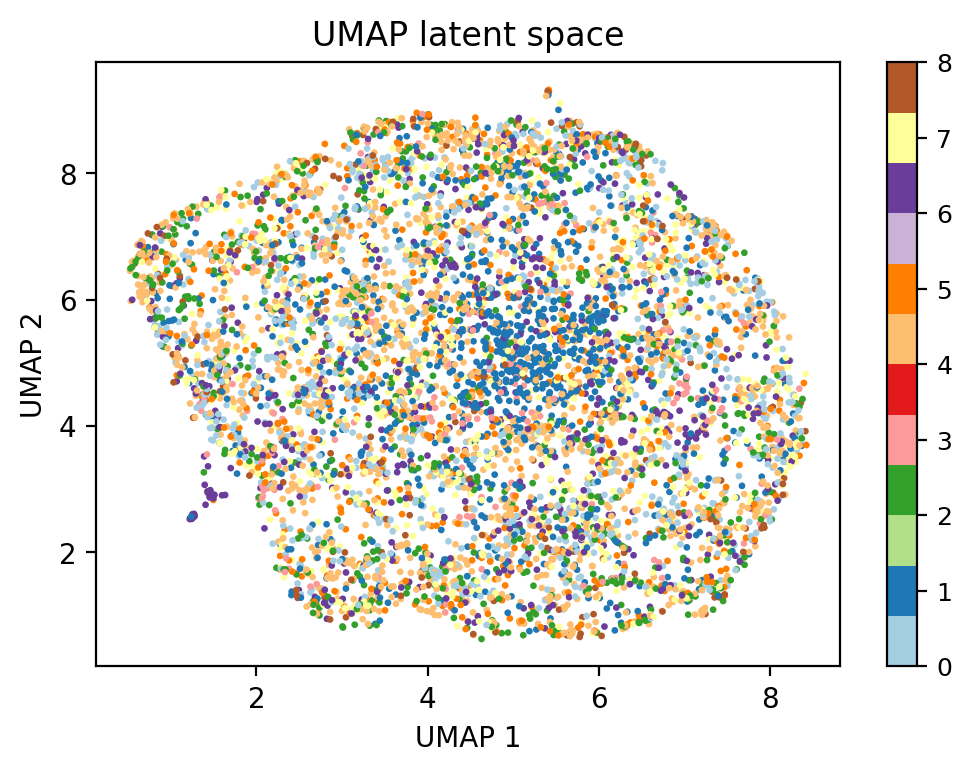

In [53]:

umaper, X = basic_umap(_data_loader,10,[dico_label[s] for s in list_files])

In [33]:
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score



def getSilhouetteProfile( X , nb_clusters ):
    """
    Takes:
        - X (np.array | pd.DataFrame): data to perform the clustering. Preferably scaled or from a pca
        - nb_clusters (iterable): list containing the different number of clusters to test
   
    Returns:
        (tuple) : (list) : inertia values corresponding to each number of clusters values
                  (list) : silhouette values corresponding to each number of clusters values
               
    """

    inertias = []
    silhouettes = []
    for n in nb_clusters:
        kmeans = cluster.KMeans(n)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X,kmeans.labels_))
    return inertias , silhouettes

def clusters_kmean(data):
   
   
    nr_clusters = np.arange(15)+2
    inertias , silhouettes = getSilhouetteProfile( data , nr_clusters )

    ## getting the K with maximum silhouette
    bestI = np.argmax( silhouettes )
    bestK = nr_clusters[bestI]
    print('best K :',bestK)

    plt.subplots(figsize=(15,7))

    plt.subplot(1,2,1)
    plt.plot(nr_clusters, inertias, ls="-", lw=2)
    plt.xlabel('Number of clusters',fontsize=20)
    plt.ylabel('Inertia',fontsize=20)
    plt.title('k-means clustering',fontsize=20)

    plt.subplot(1,2,2)
    plt.plot(nr_clusters, silhouettes, ls="-", lw=2)
    plt.xlabel('Number of clusters',fontsize=20)
    plt.ylabel('Silhouette  score',fontsize=20)
    plt.title('k-means clustering',fontsize=20)

    plt.tight_layout()
    plt.show()
   
    kmeans_means = cluster.KMeans(bestK)
    kmeans_means.fit(data)
    return kmeans_means

best K : 2


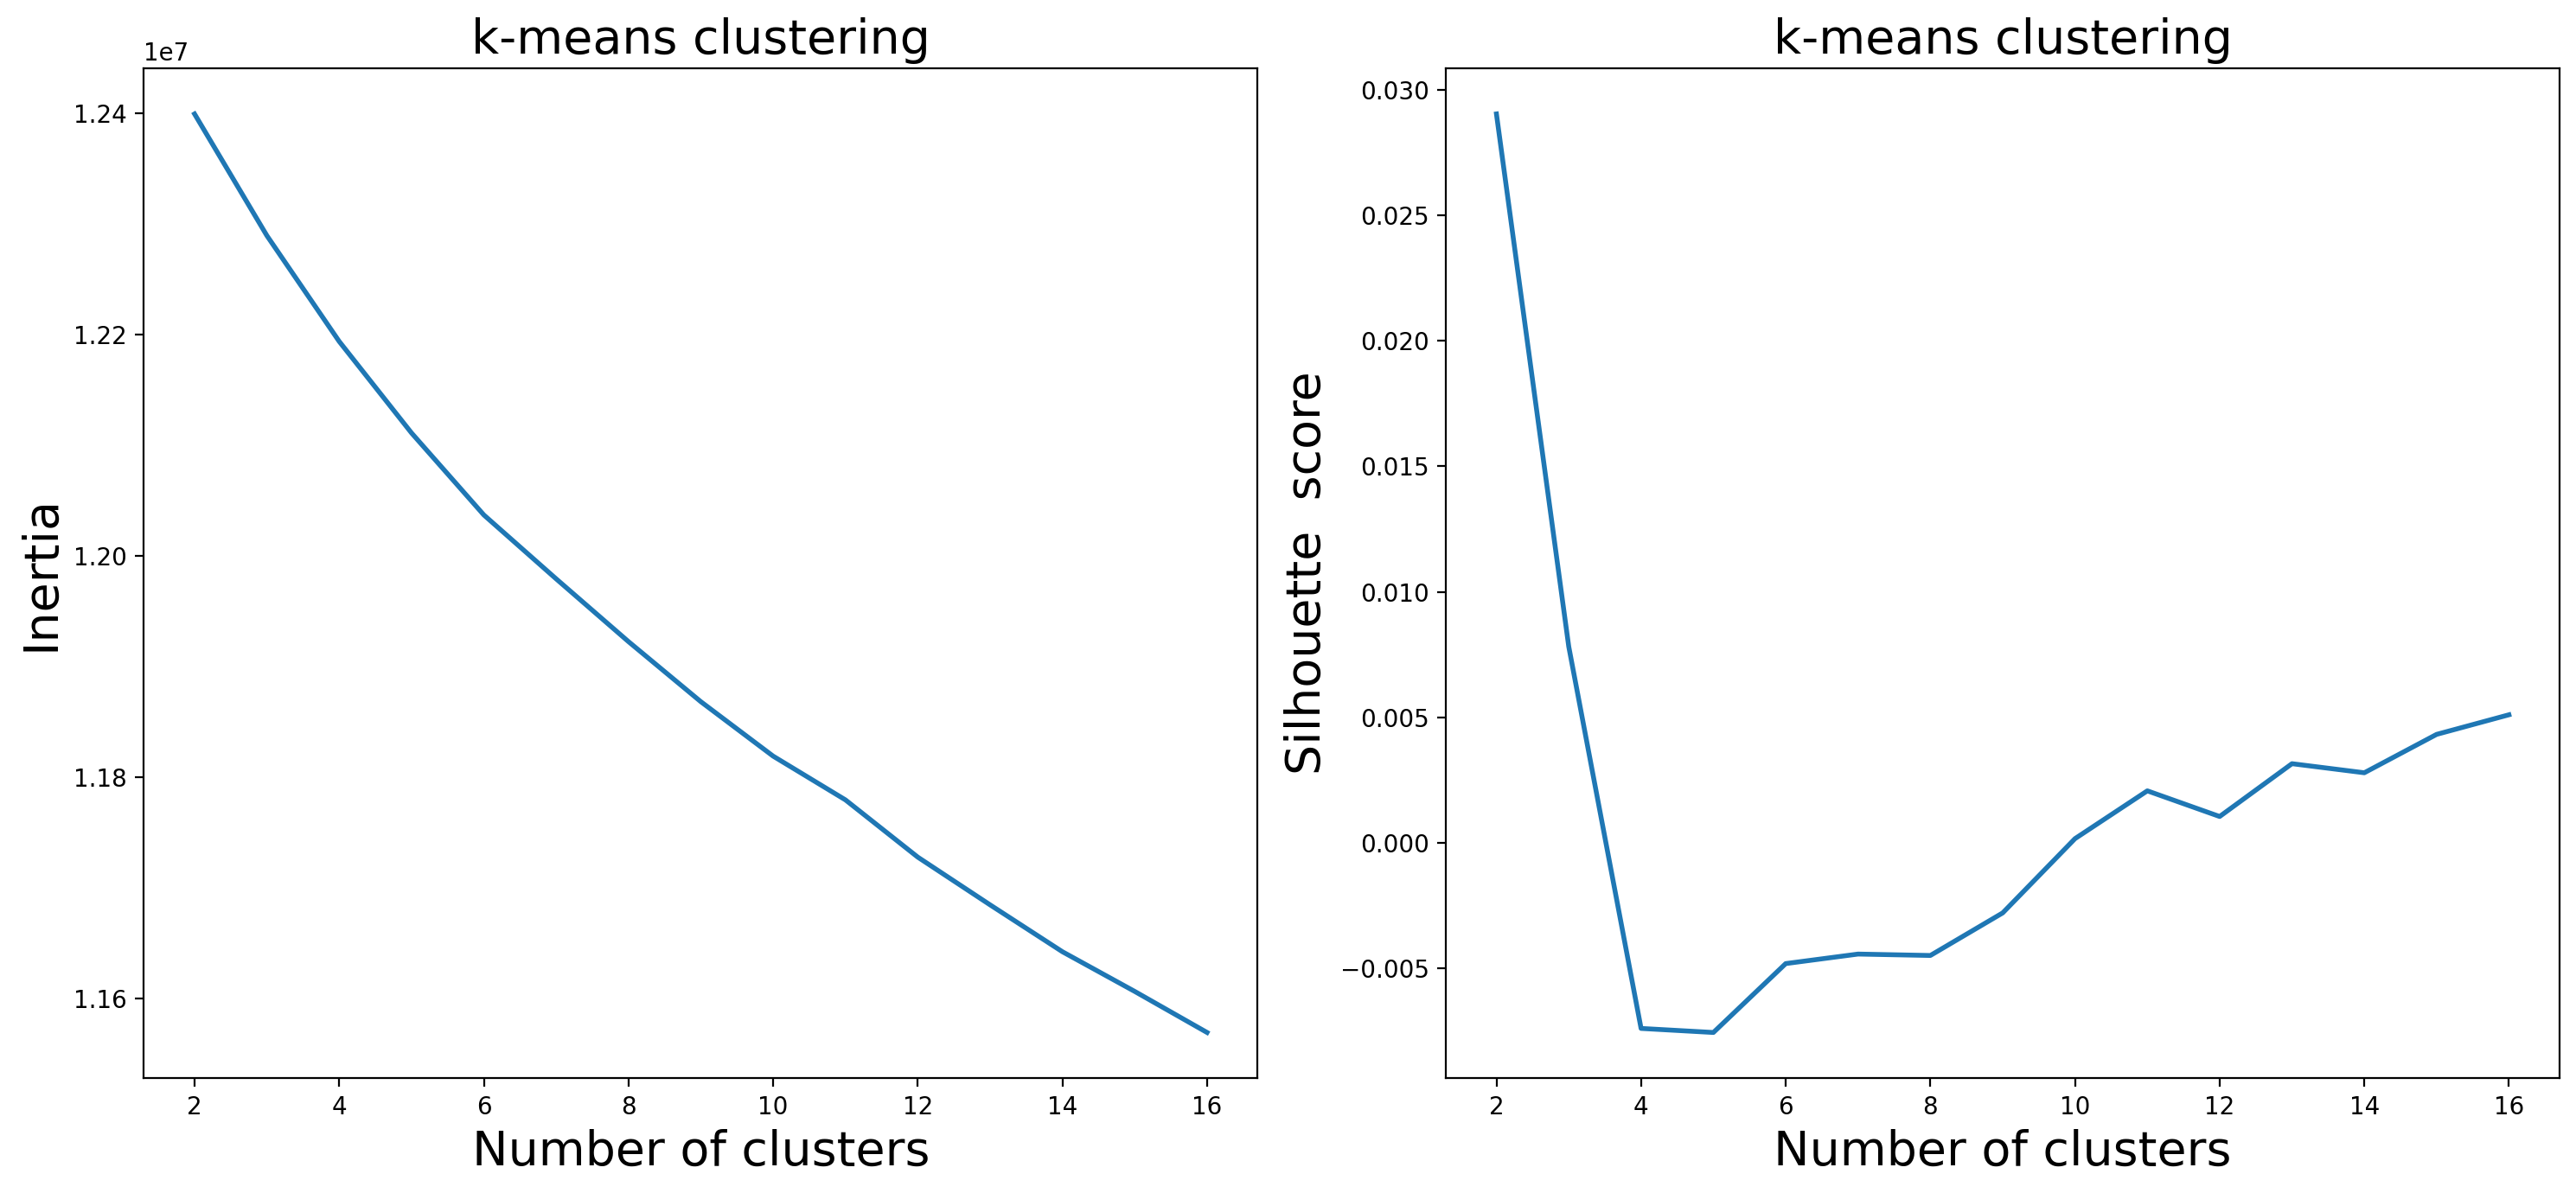

In [34]:
kmeans_means = clusters_kmean(X)

In [35]:
#I only draw one sample from the Gaussian in the latent space
encoded_decoded_data=[]
for data in _data_loader:
    encoded_decoded_data.append(pyrovae.reconstruct_ecg(data.to(device)).detach().cpu().numpy())

In [36]:
encoded_decoded_data_array=np.vstack(encoded_decoded_data)

In [37]:
actual_data=[]
for data in _data_loader:
    actual_data.append(data)
    
actual_data_array=np.vstack(actual_data)

In [38]:
actual_data_array.shape[0]*12

82524

In [39]:
from scipy.stats import pearsonr

In [40]:
core=[]
for i,j in zip(encoded_decoded_data_array,actual_data_array):
    for k in range(encoded_decoded_data_array.shape[1]):
        core.append(pearsonr(i[k],j[k])[0])

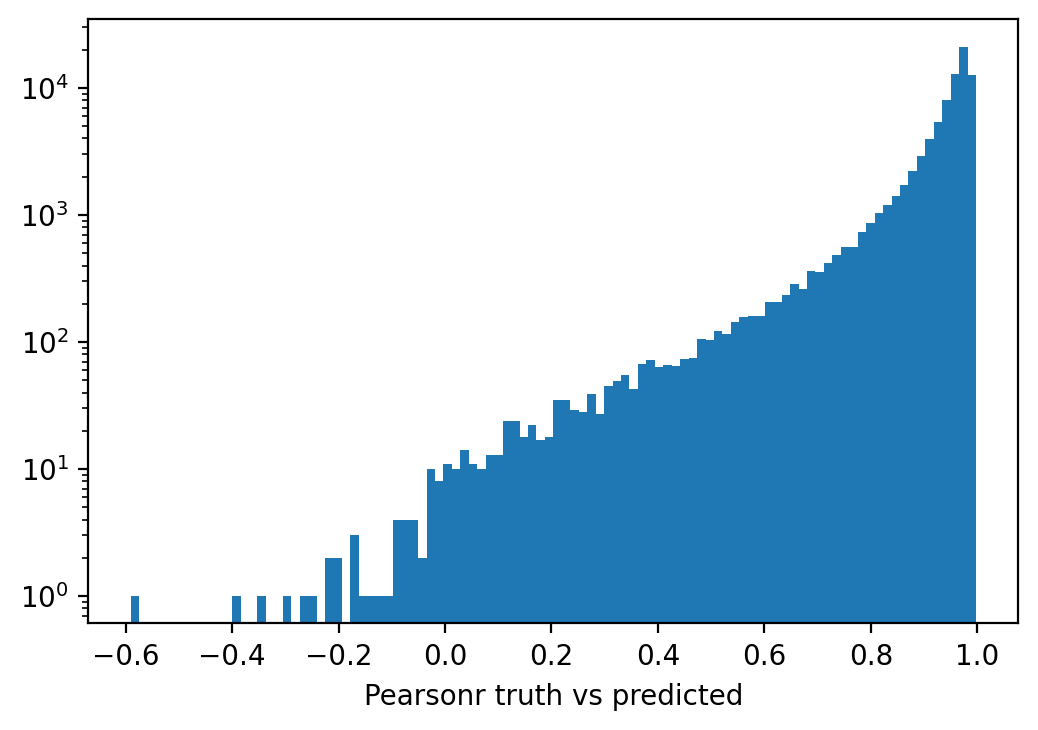

In [41]:
plt.hist(core,100)
plt.yscale('log')
plt.xlabel('Pearsonr truth vs predicted')
plt.show()

In [42]:
##I am plotting just 1 draw per latent representation : I could draw more and have confidence interval
def plot_truth_and_predict(truth,predict):
    fig,ax=plt.subplots(4,3,sharex=True, sharey=True)
    yaya=np.arange(truth.shape[1])
    for k in range(12):
        plt.subplot(4,3,k+1)
        plt.title(leads[k],fontsize=4)
        plt.plot(yaya, truth[k],linewidth=1,alpha=1,c='b',label='truth')
        plt.plot(yaya, predict[k],linewidth=1,alpha=1,c='r',label='predict')
        plt.legend(loc='best',fontsize=5)
    plt.tight_layout()
    plt.show()

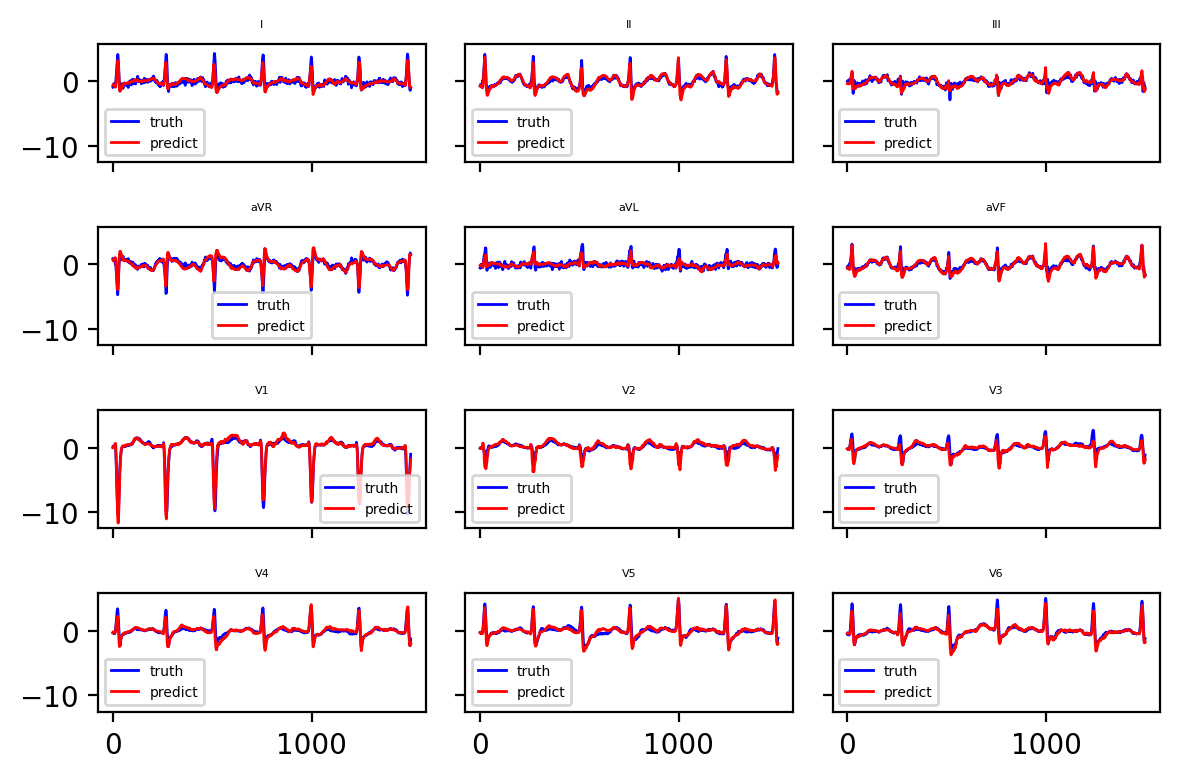

In [43]:
h=0
plot_truth_and_predict(actual_data_array[h],encoded_decoded_data_array[h])

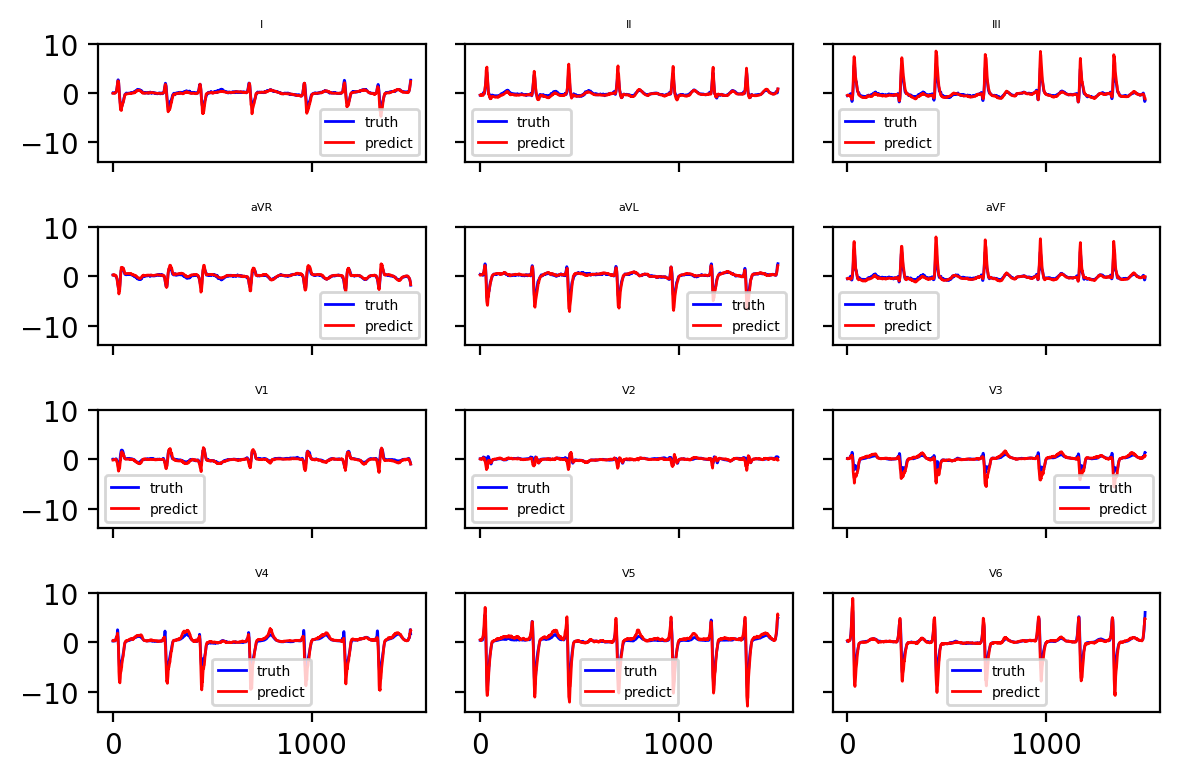

In [44]:
h=1
plot_truth_and_predict(actual_data_array[h],encoded_decoded_data_array[h])

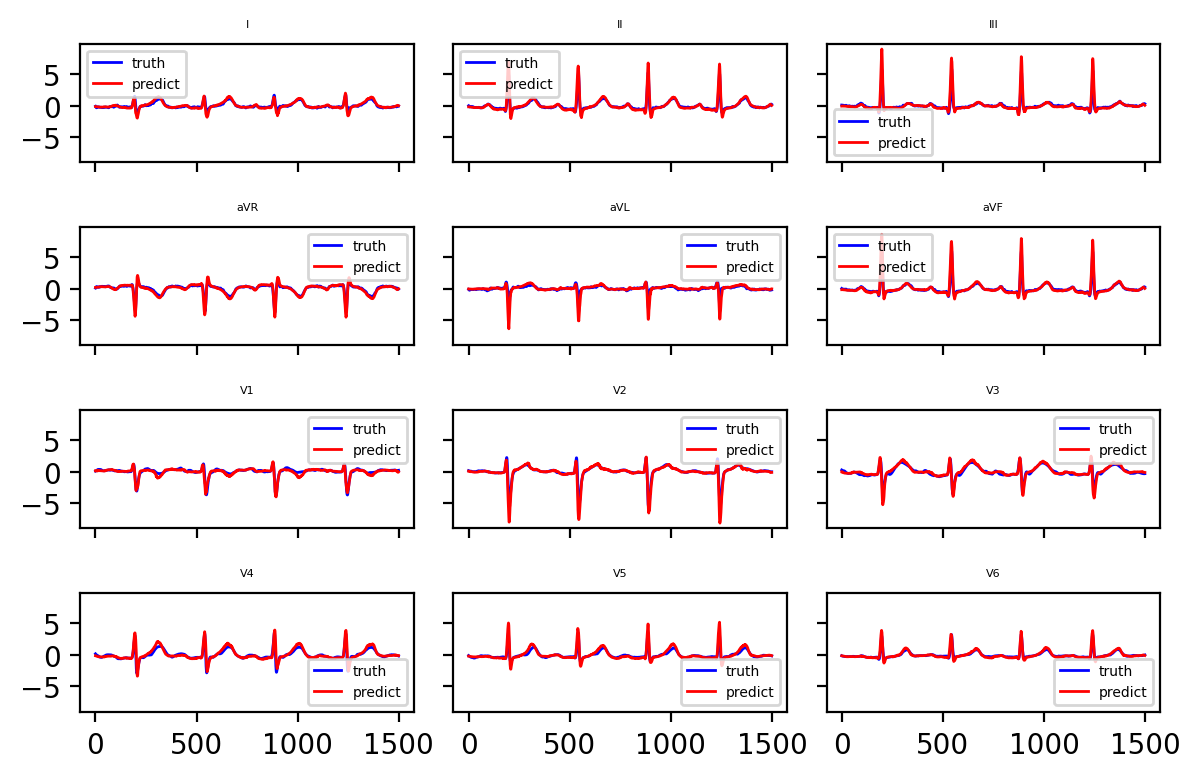

In [45]:
h=10
plot_truth_and_predict(actual_data_array[h],encoded_decoded_data_array[h])

In [46]:
actual_data_array.shape

(6877, 12, 1500)

In [47]:
f_actual_data_array=actual_data_array.reshape(actual_data_array.shape[0],-1)

In [48]:
f_actual_data_array.shape

(6877, 18000)

# Just looking for the best generative probability distribution ( I chose Asymetrical Laplace)

In [49]:

def histo_plot(i):
    fig,ax=plt.subplots(1,3,figsize=(15,5))
    lou=sorted(f_actual_data_array[:,i])
    m=np.mean(lou)
    std=np.std(lou)
    rv = scipy.stats.laplace(loc=m,scale=std/(2)**0.5)
    ax[0].hist(f_actual_data_array[:,i],100,density=True)
    x = np.linspace(rv.ppf(0.0001),
                rv.ppf(0.9999), 1000)
    ax[0].plot(x, rv.pdf(x), 'k-', lw=2)
    #ax[0].set_title(str(m)[:5]+'  '+str(std)[:5])
    
   
    ax[1].scatter(np.arange(0,1,1./len(lou)),[rv.cdf(h) for h in lou])
    ax[1].plot([0,1],[0,1],'--')
    
    ax[2].scatter(lou,[rv.ppf(h*1./len(lou)) for h in range(len(lou))])
    ax[2].plot(lou,lou,'--')
    
    
    ax[0].set_xlabel('score')
    ax[0].set_ylabel('fraction')
    
    ax[0].set_title('Pmf-Pmf plot')
    
    ax[1].set_xlabel('True proba')
    ax[1].set_ylabel('Model proba')
    
    ax[1].set_title('P-P plot')
    
    ax[2].set_xlabel('True score')
    ax[2].set_ylabel('Model score')
    ax[2].set_title('Q-Q plot')
    #plt.legend(loc='best')
    #plt.title(v[0])
    fig.suptitle(str(m)[:5]+'  '+str(std)[:5]+' laplace')
    plt.tight_layout()
    plt.show()

In [50]:
1/(2)**0.5

0.7071067811865475

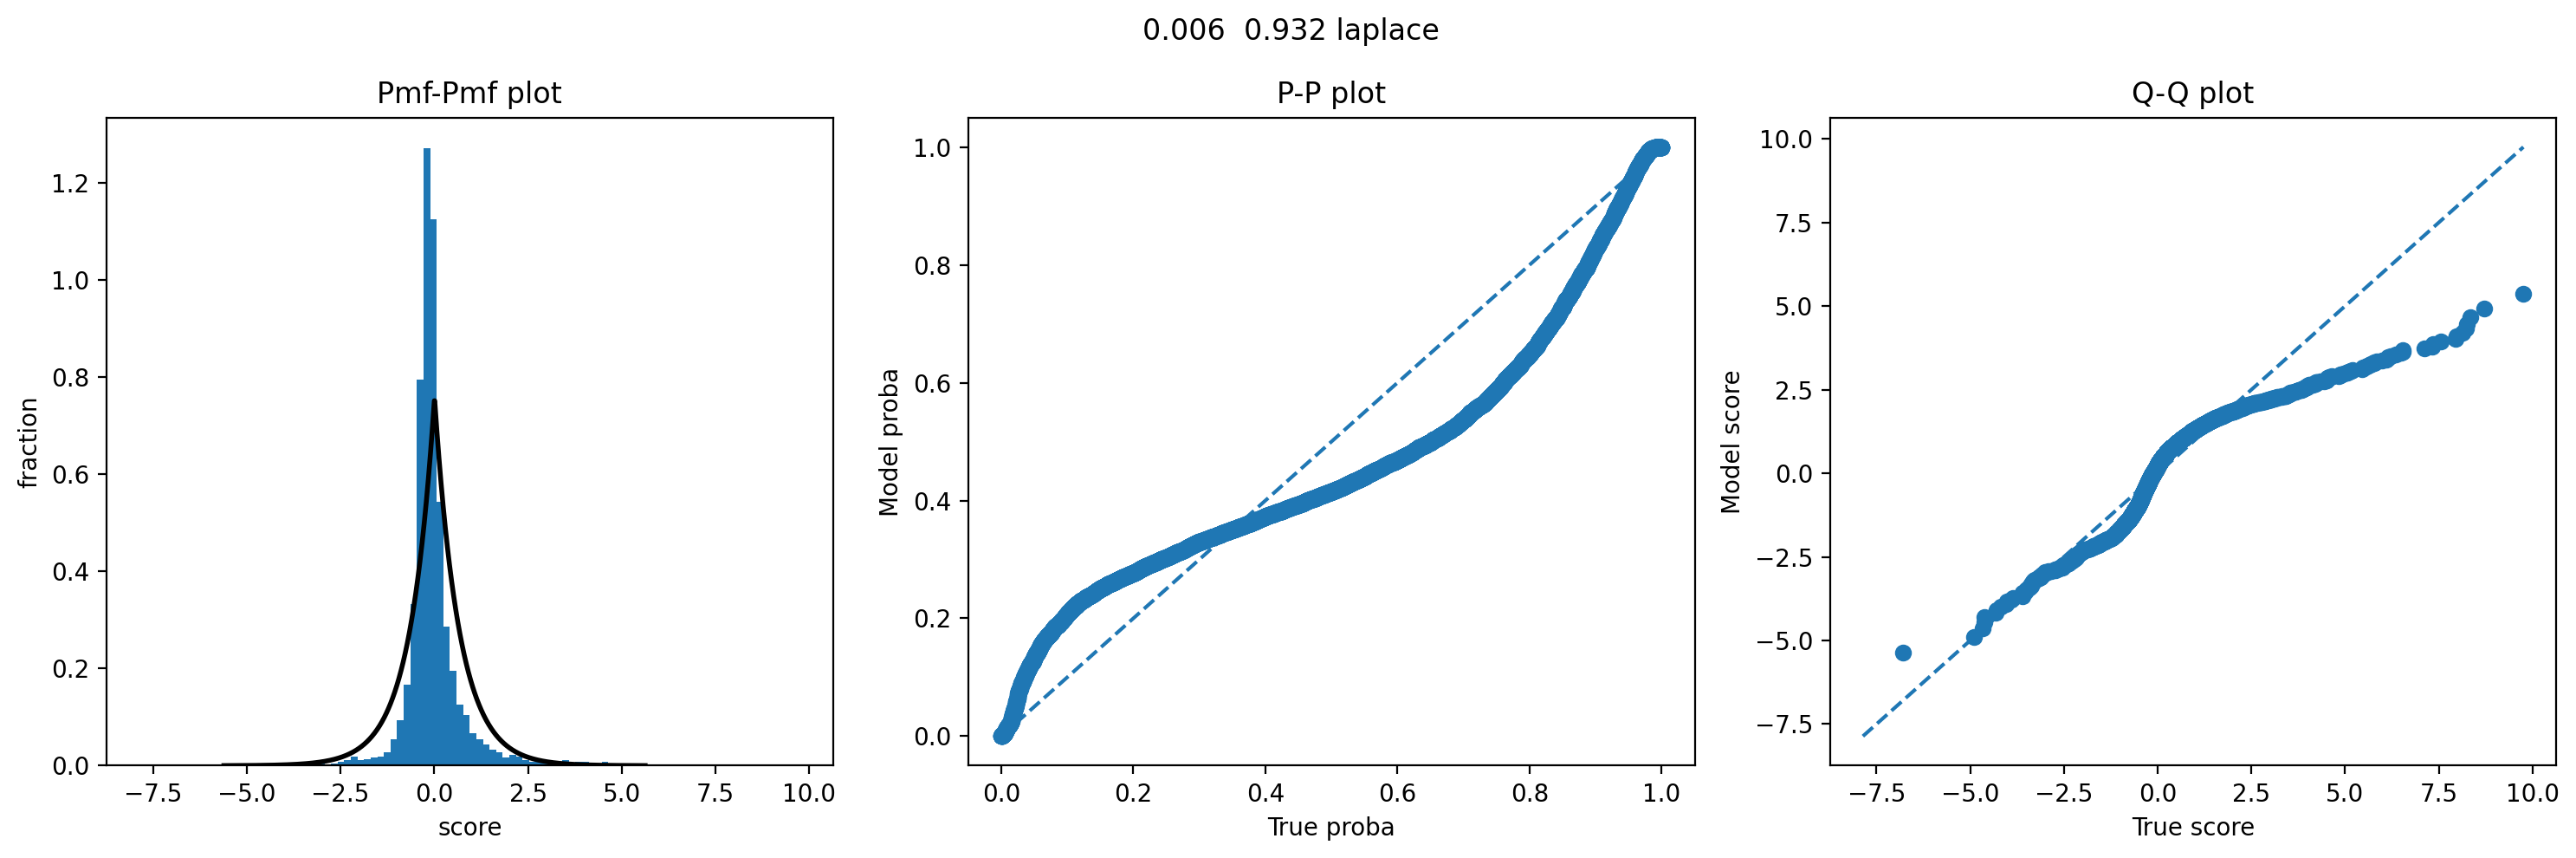

In [51]:
histo_plot(0)

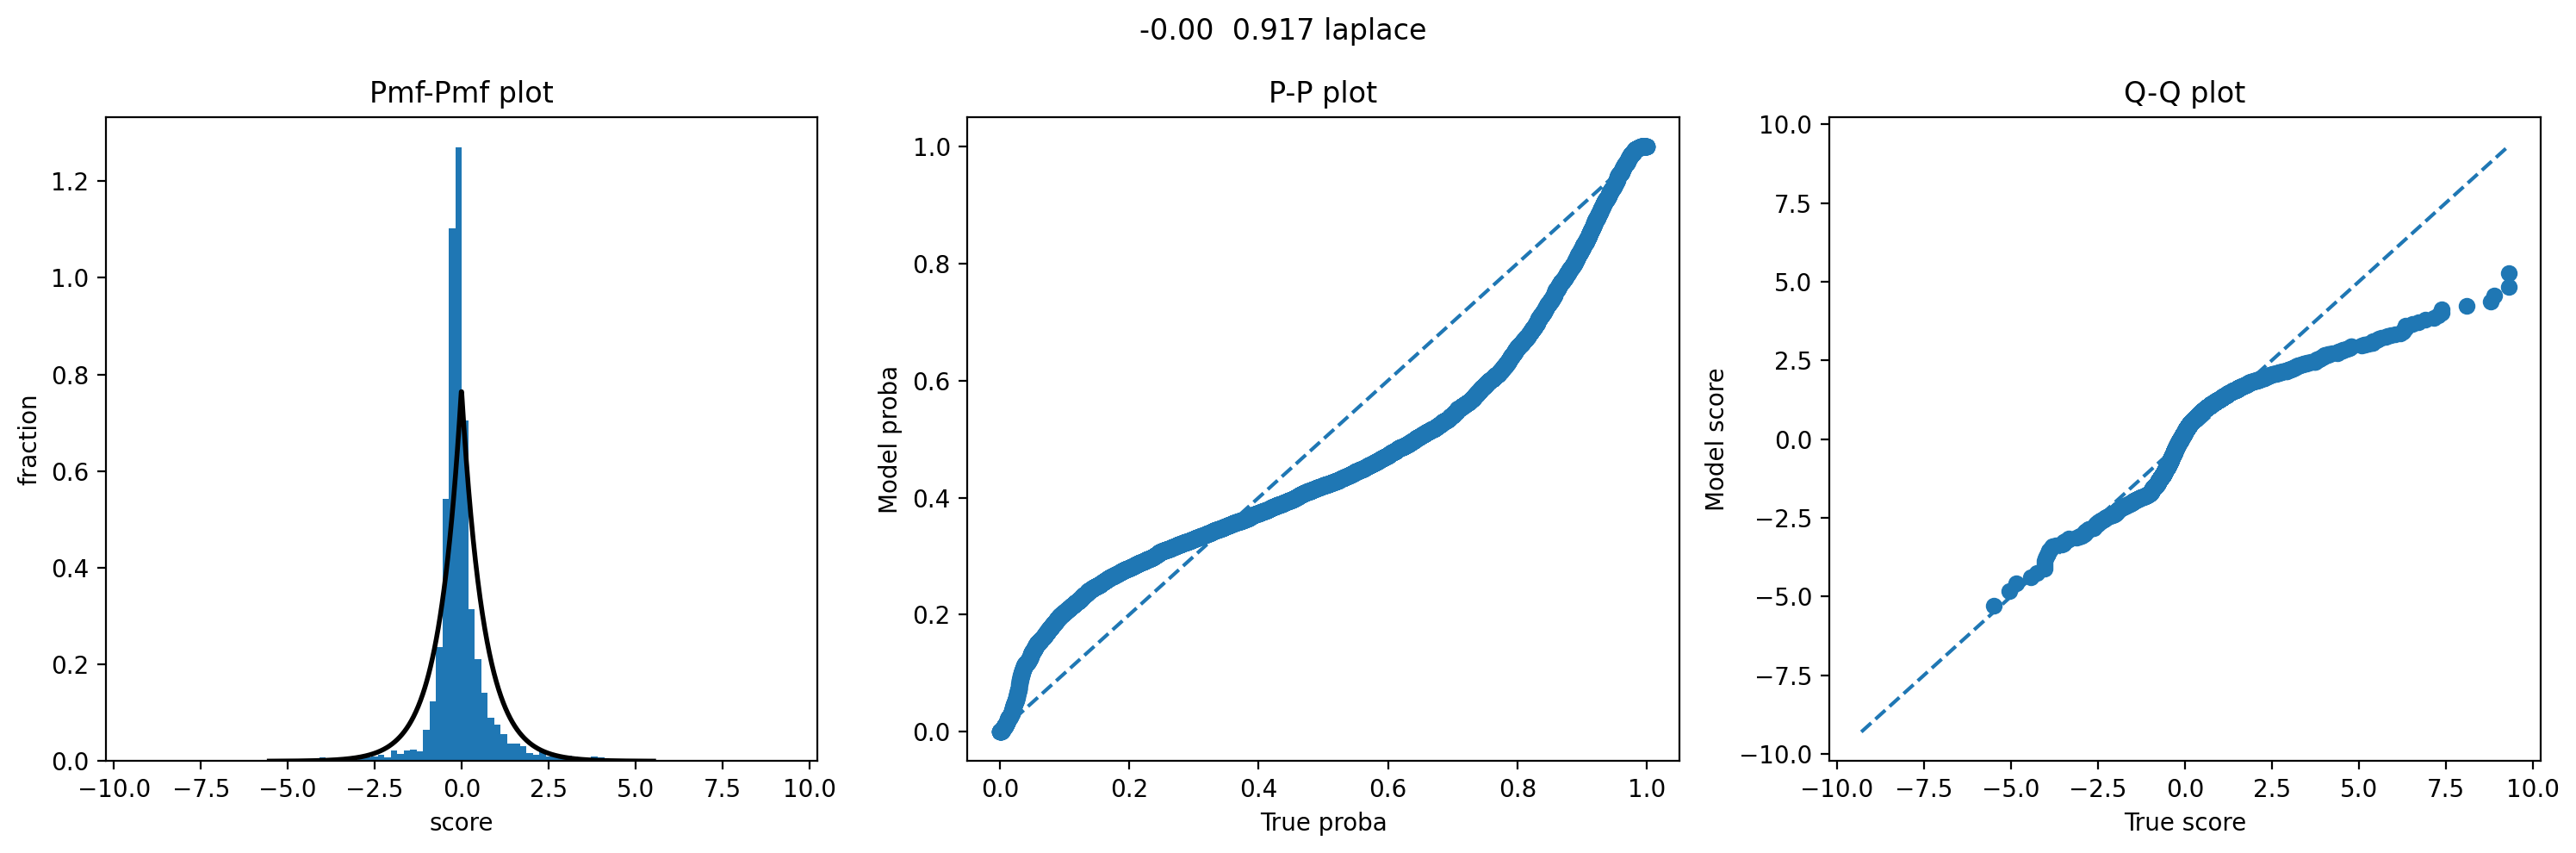

In [52]:

histo_plot(100)

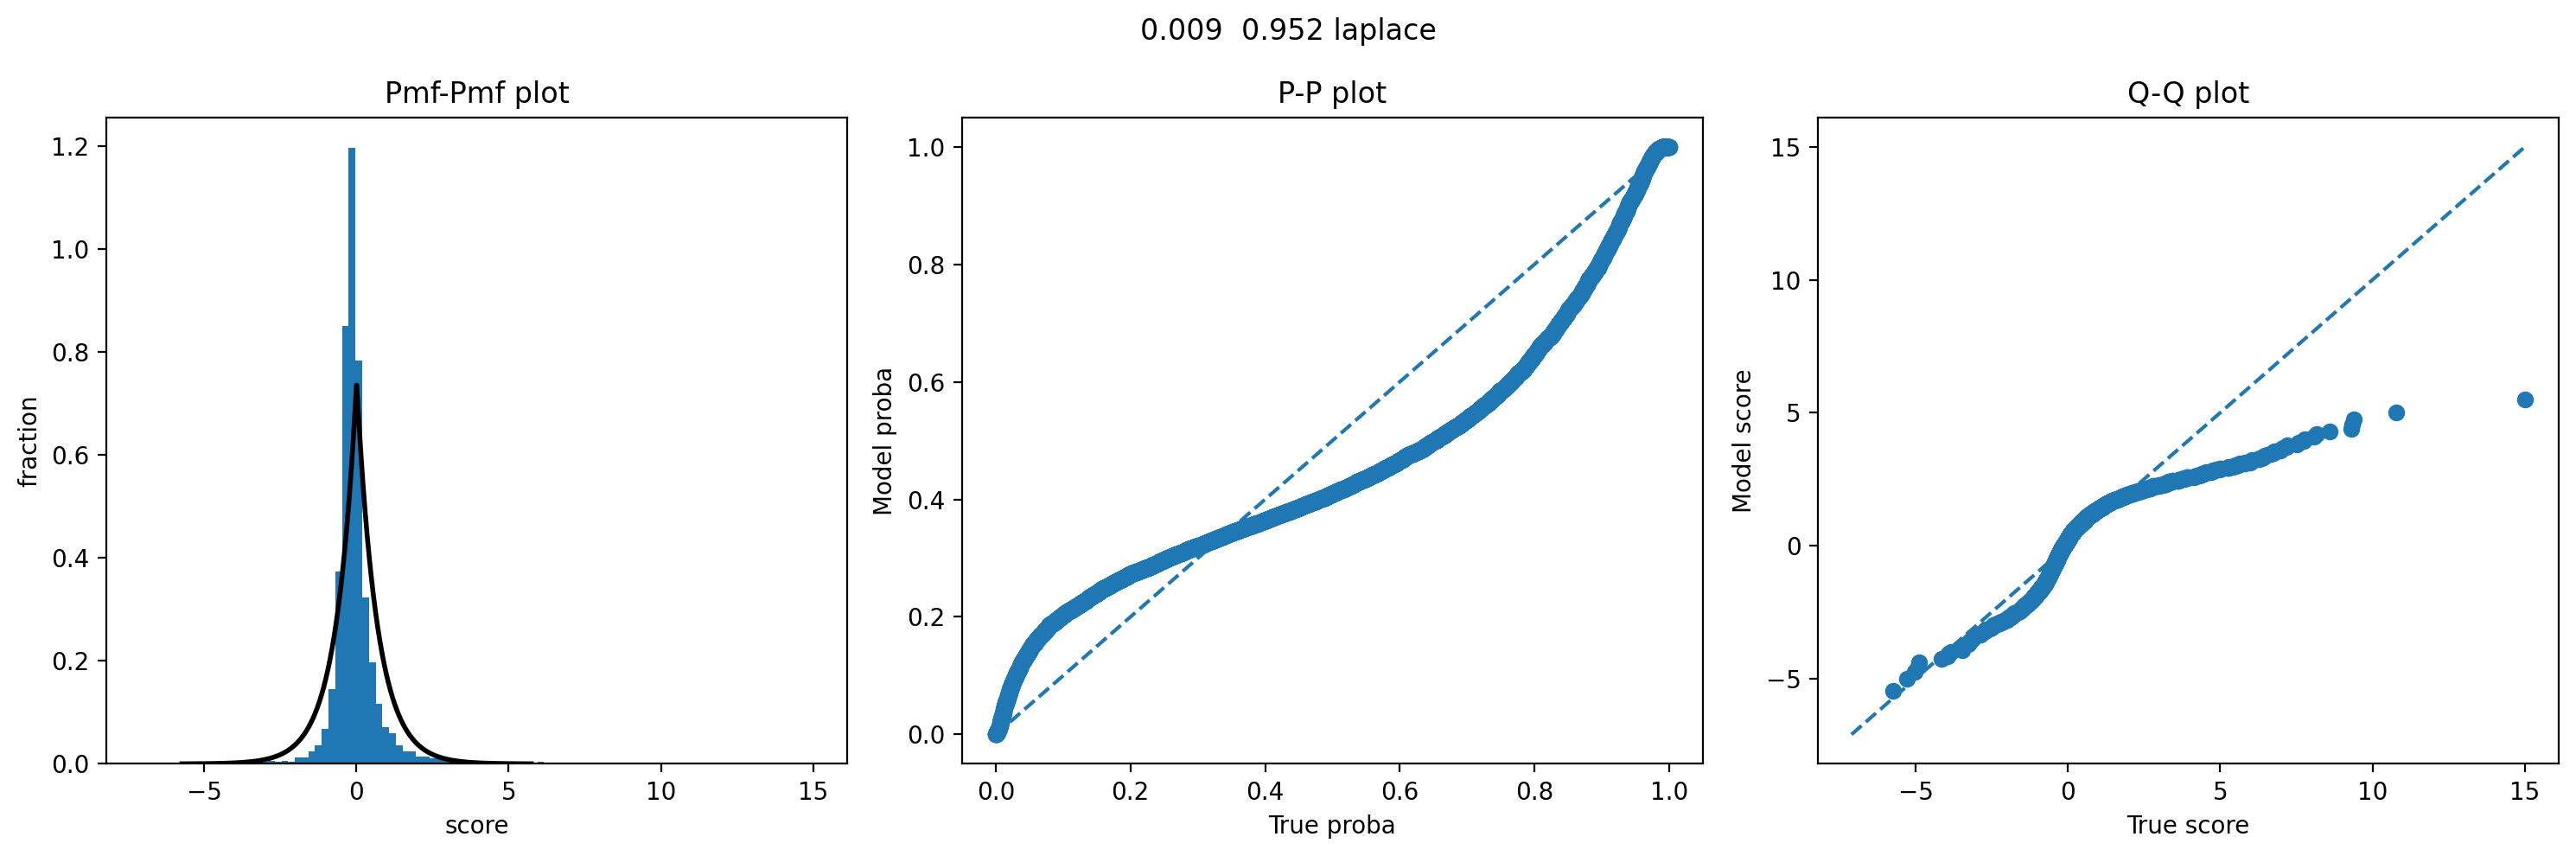

In [52]:
histo_plot(1600)

In [53]:
def histo_plot_norm(i):
    fig,ax=plt.subplots(1,3,figsize=(15,5))
    lou=sorted(f_actual_data_array[:,i])
    m=np.mean(lou)
    std=np.std(lou)
    rv = scipy.stats.norm(loc=m,scale=std)
    ax[0].hist(f_actual_data_array[:,i],100,density=True)
    x = np.linspace(rv.ppf(0.0001),
                rv.ppf(0.9999), 1000)
    ax[0].plot(x, rv.pdf(x), 'k-', lw=2)
    #ax[0].set_title(str(m)[:5]+'  '+str(std)[:5])
    
   
    ax[1].scatter(np.arange(0,1,1./len(lou)),[rv.cdf(h) for h in lou])
    ax[1].plot([0,1],[0,1],'--')
    ax[2].scatter(lou,[rv.ppf(h*1./len(lou)) for h in range(len(lou))])
    ax[2].plot(lou,lou,'--')
    
    ax[0].set_xlabel('score')
    ax[0].set_ylabel('fraction')
    
    ax[0].set_title('Pmf-Pmf plot')
    
    ax[1].set_xlabel('True proba')
    ax[1].set_ylabel('Model proba')
    
    ax[1].set_title('P-P plot')
    
    ax[2].set_xlabel('True score')
    ax[2].set_ylabel('Model score')
    ax[2].set_title('Q-Q plot')
    #plt.legend(loc='best')
    #plt.title(v[0])
    fig.suptitle(str(m)[:5]+'  '+str(std)[:5]+' laplace')
    plt.show()

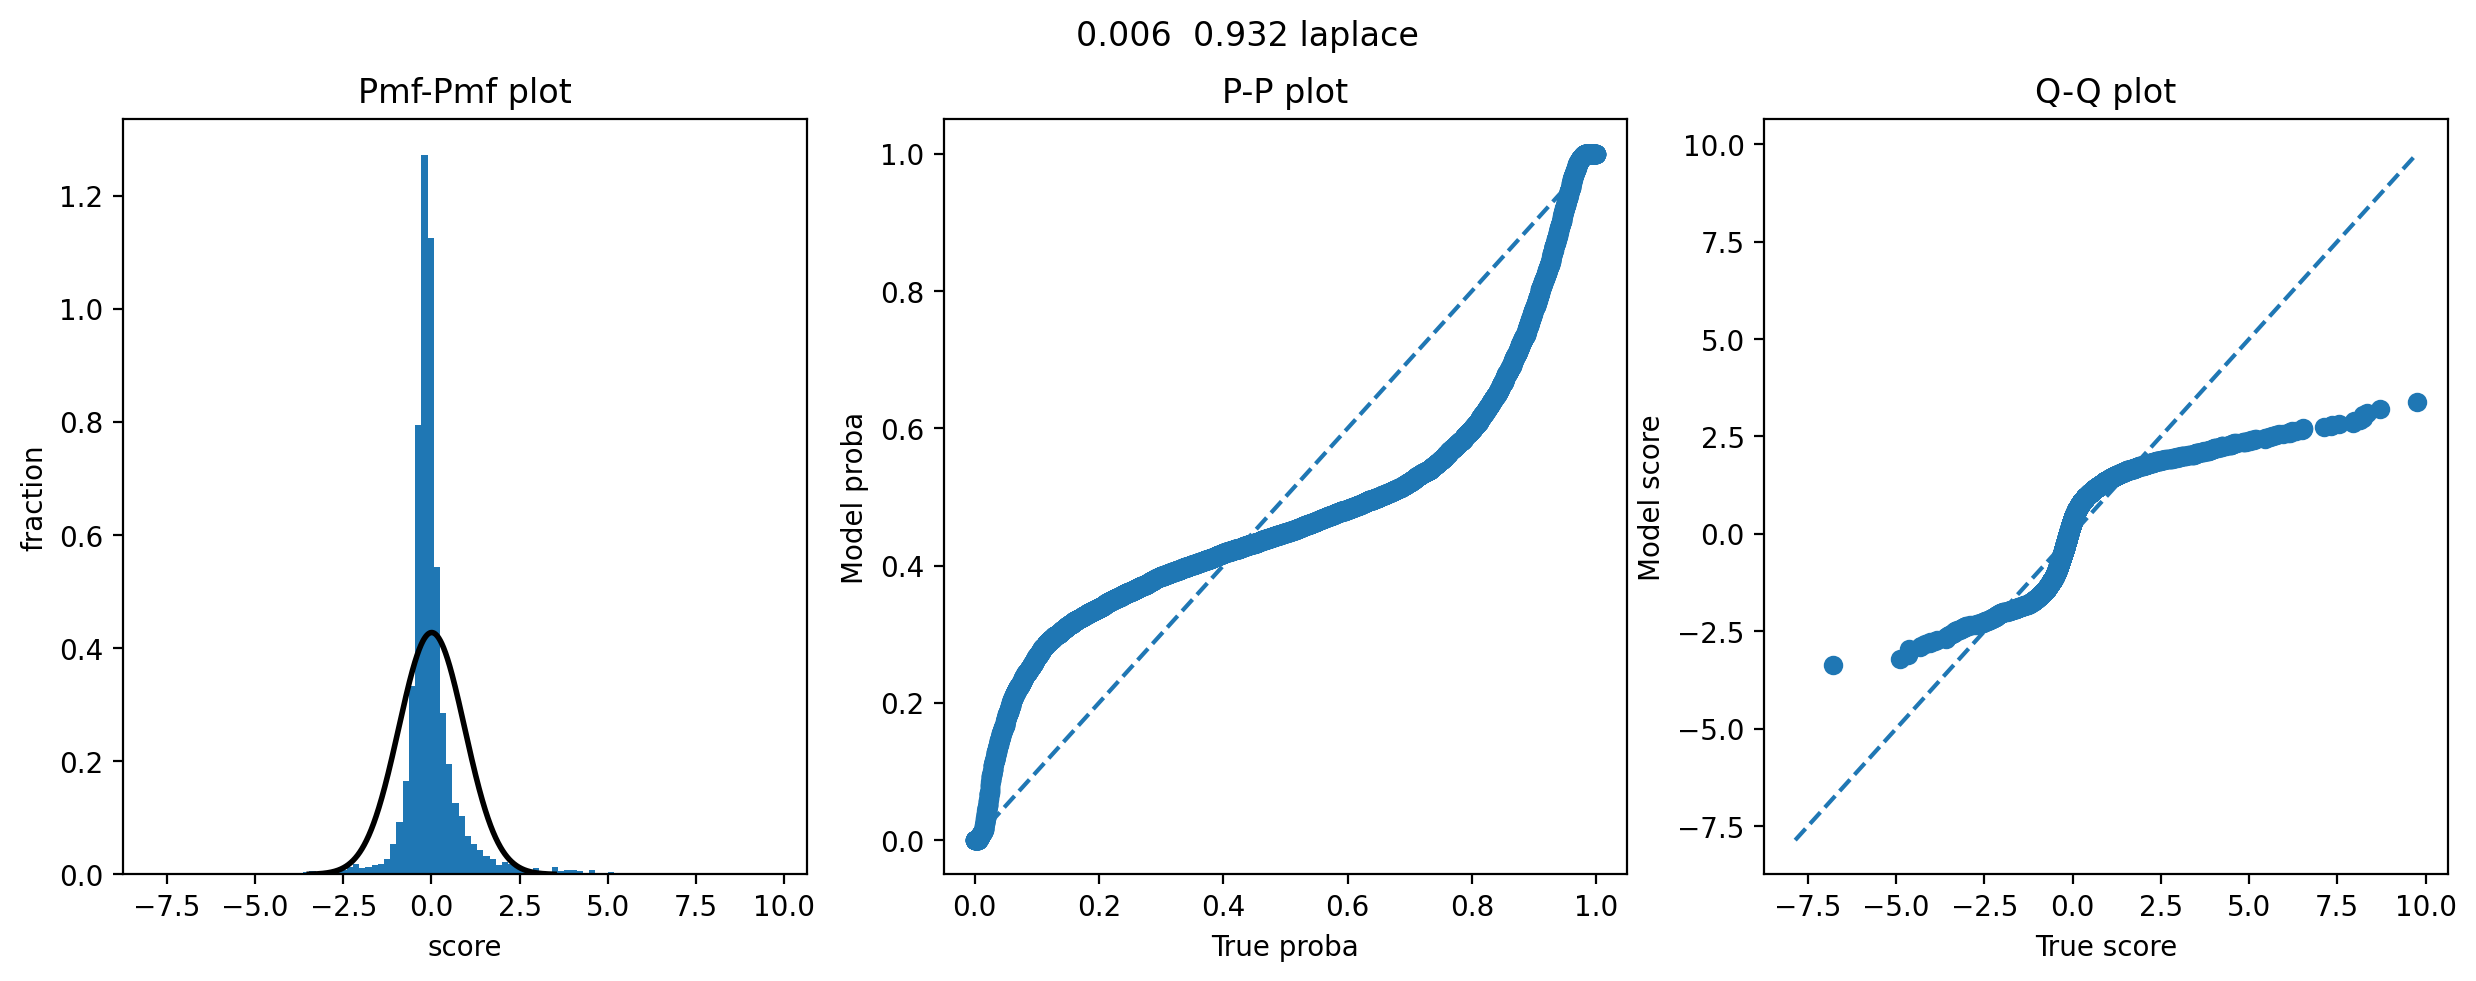

In [54]:
histo_plot_norm(0)

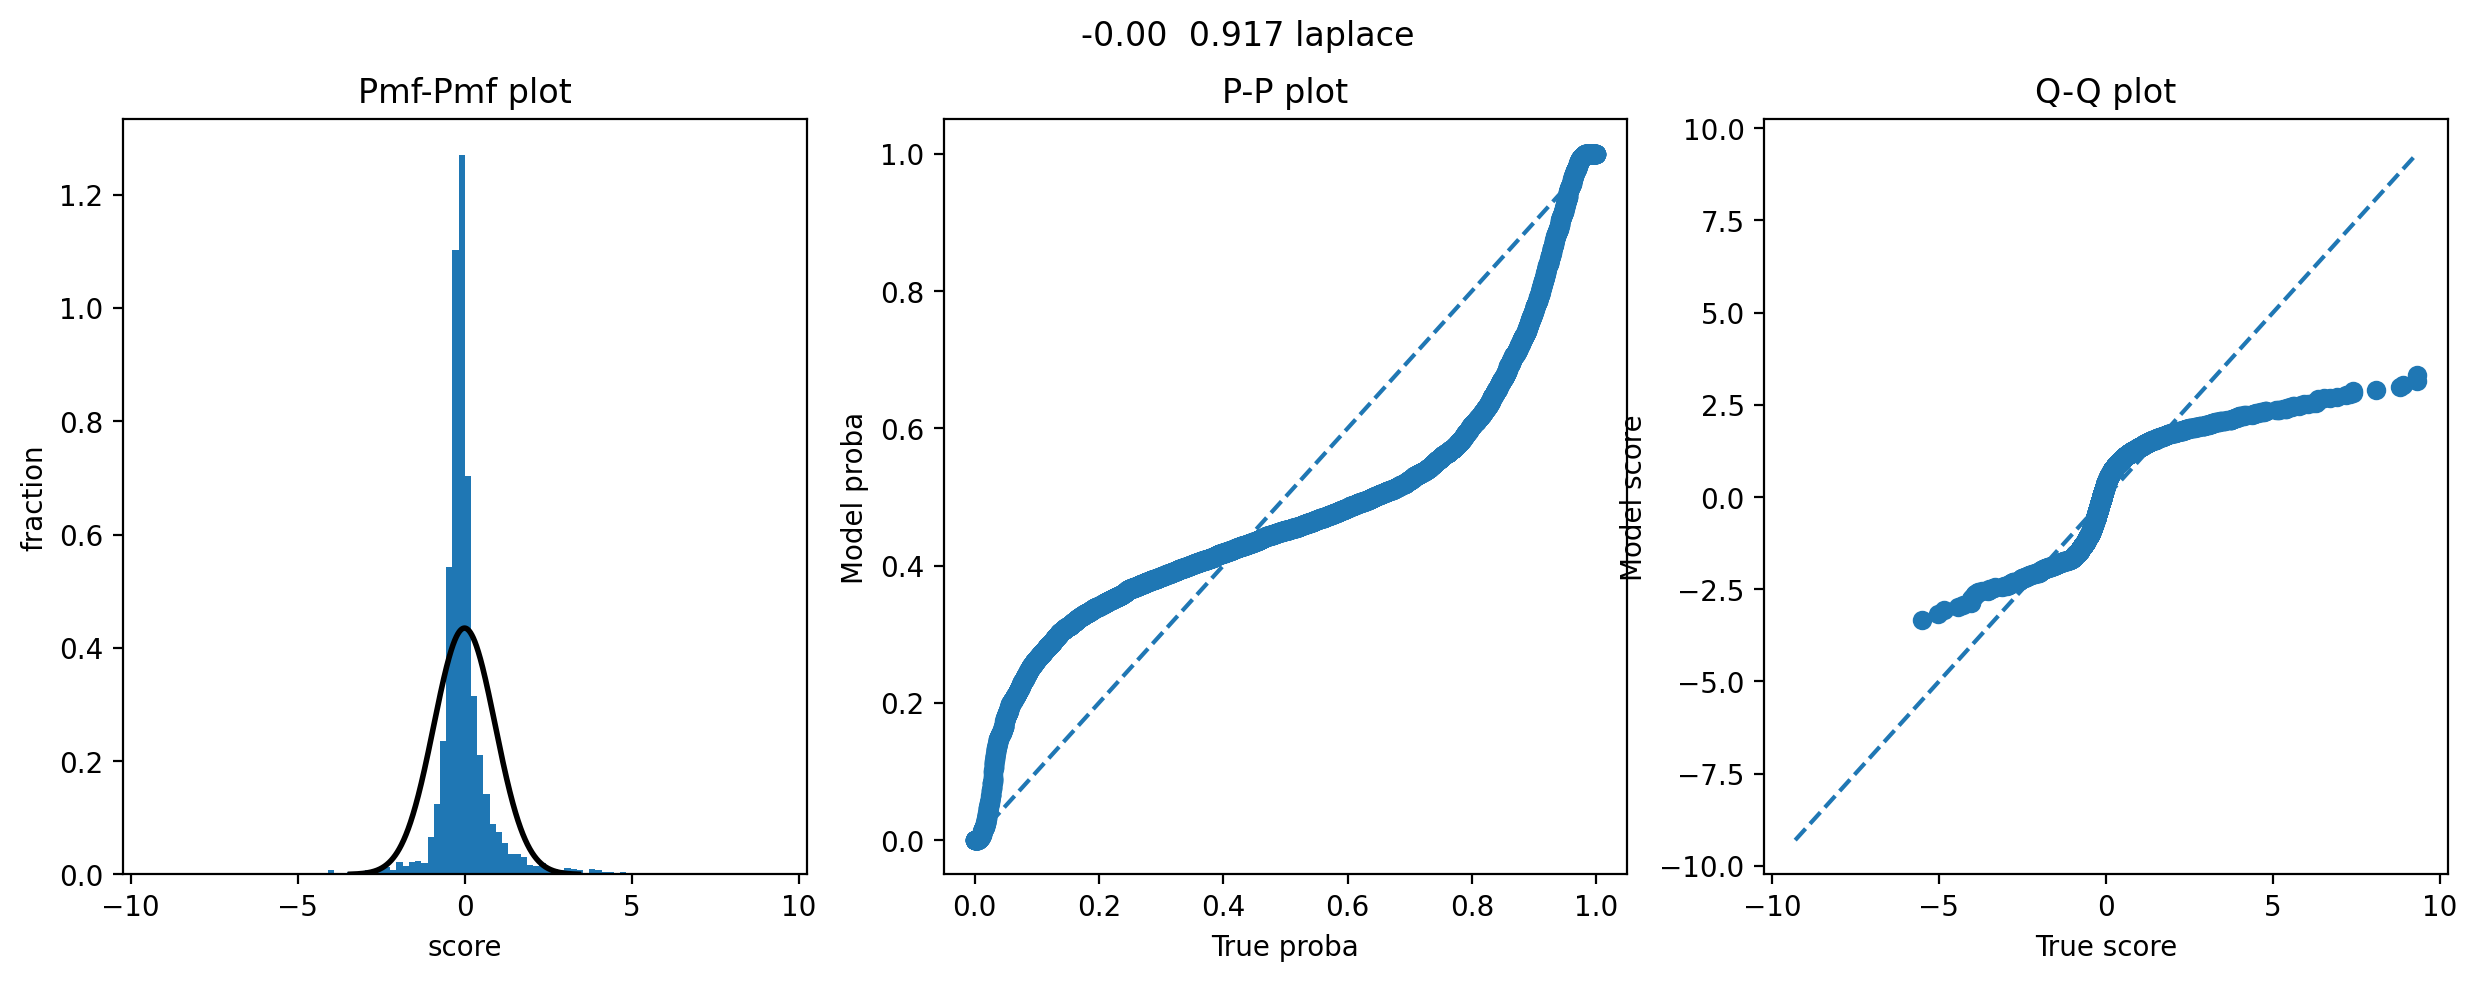

In [55]:
histo_plot_norm(100)

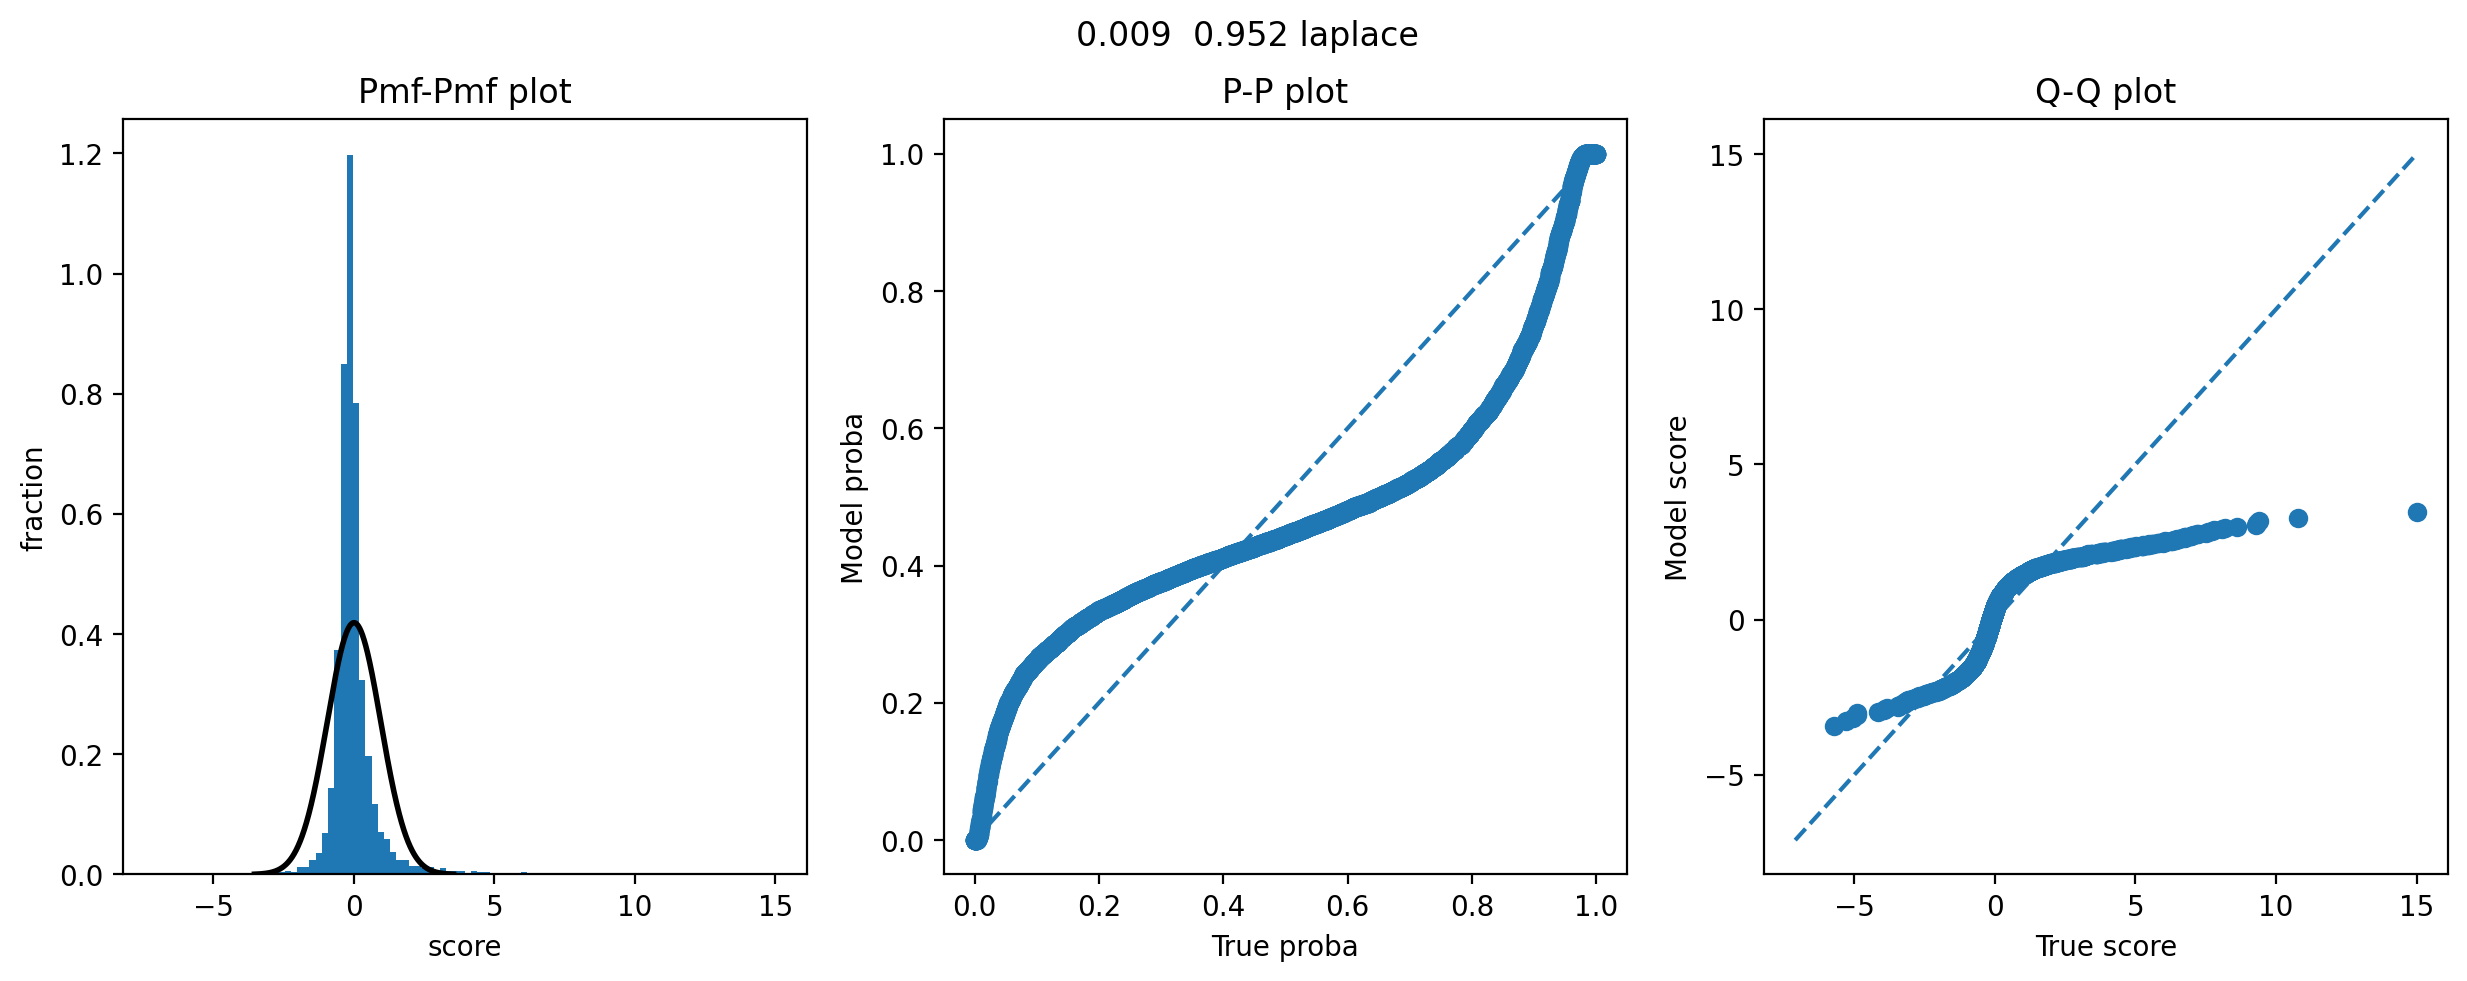

In [56]:
histo_plot_norm(1600)

In [57]:
def histo_plot_cauchy(i):
    fig,ax=plt.subplots(1,3,figsize=(15,5))
    lou=sorted(f_actual_data_array[:,i])
    m=np.mean(lou)
    std=np.std(lou)
    rv = scipy.stats.cauchy(loc=m,scale=0.21)
    #rv = scipy.stats.cauchy(loc=m,scale=std*10)
    ax[0].hist(f_actual_data_array[:,i],100,density=True)
    x = np.linspace(rv.ppf(0.001),
                rv.ppf(0.999), 1000)
    ax[0].plot(x, rv.pdf(x), 'k-', lw=2)
    #ax[0].set_title(str(m)[:5]+'  '+str(std)[:5])
    
   
    ax[1].scatter(np.arange(0,1,1./len(lou)),[rv.cdf(h) for h in lou])
    ax[1].plot([0,1],[0,1],'--')
    
    ax[2].scatter(lou,[rv.ppf(h*1./len(lou)) for h in range(len(lou))])
    ax[2].plot(lou,lou,'--')
    
    
    ax[0].set_xlabel('score')
    ax[0].set_ylabel('fraction')
    
    ax[0].set_title('Pmf-Pmf plot')
    
    ax[1].set_xlabel('True proba')
    ax[1].set_ylabel('Model proba')
    
    ax[1].set_title('P-P plot')
    
    ax[2].set_xlabel('True score')
    ax[2].set_ylabel('Model score')
    ax[2].set_title('Q-Q plot')
    ax[2].set_ylim([min(lou),max(lou)])
    #plt.legend(loc='best')
    #plt.title(v[0])
    fig.suptitle(str(m)[:5]+'  '+str(std)[:5]+' laplace')
    plt.tight_layout()
    plt.show()

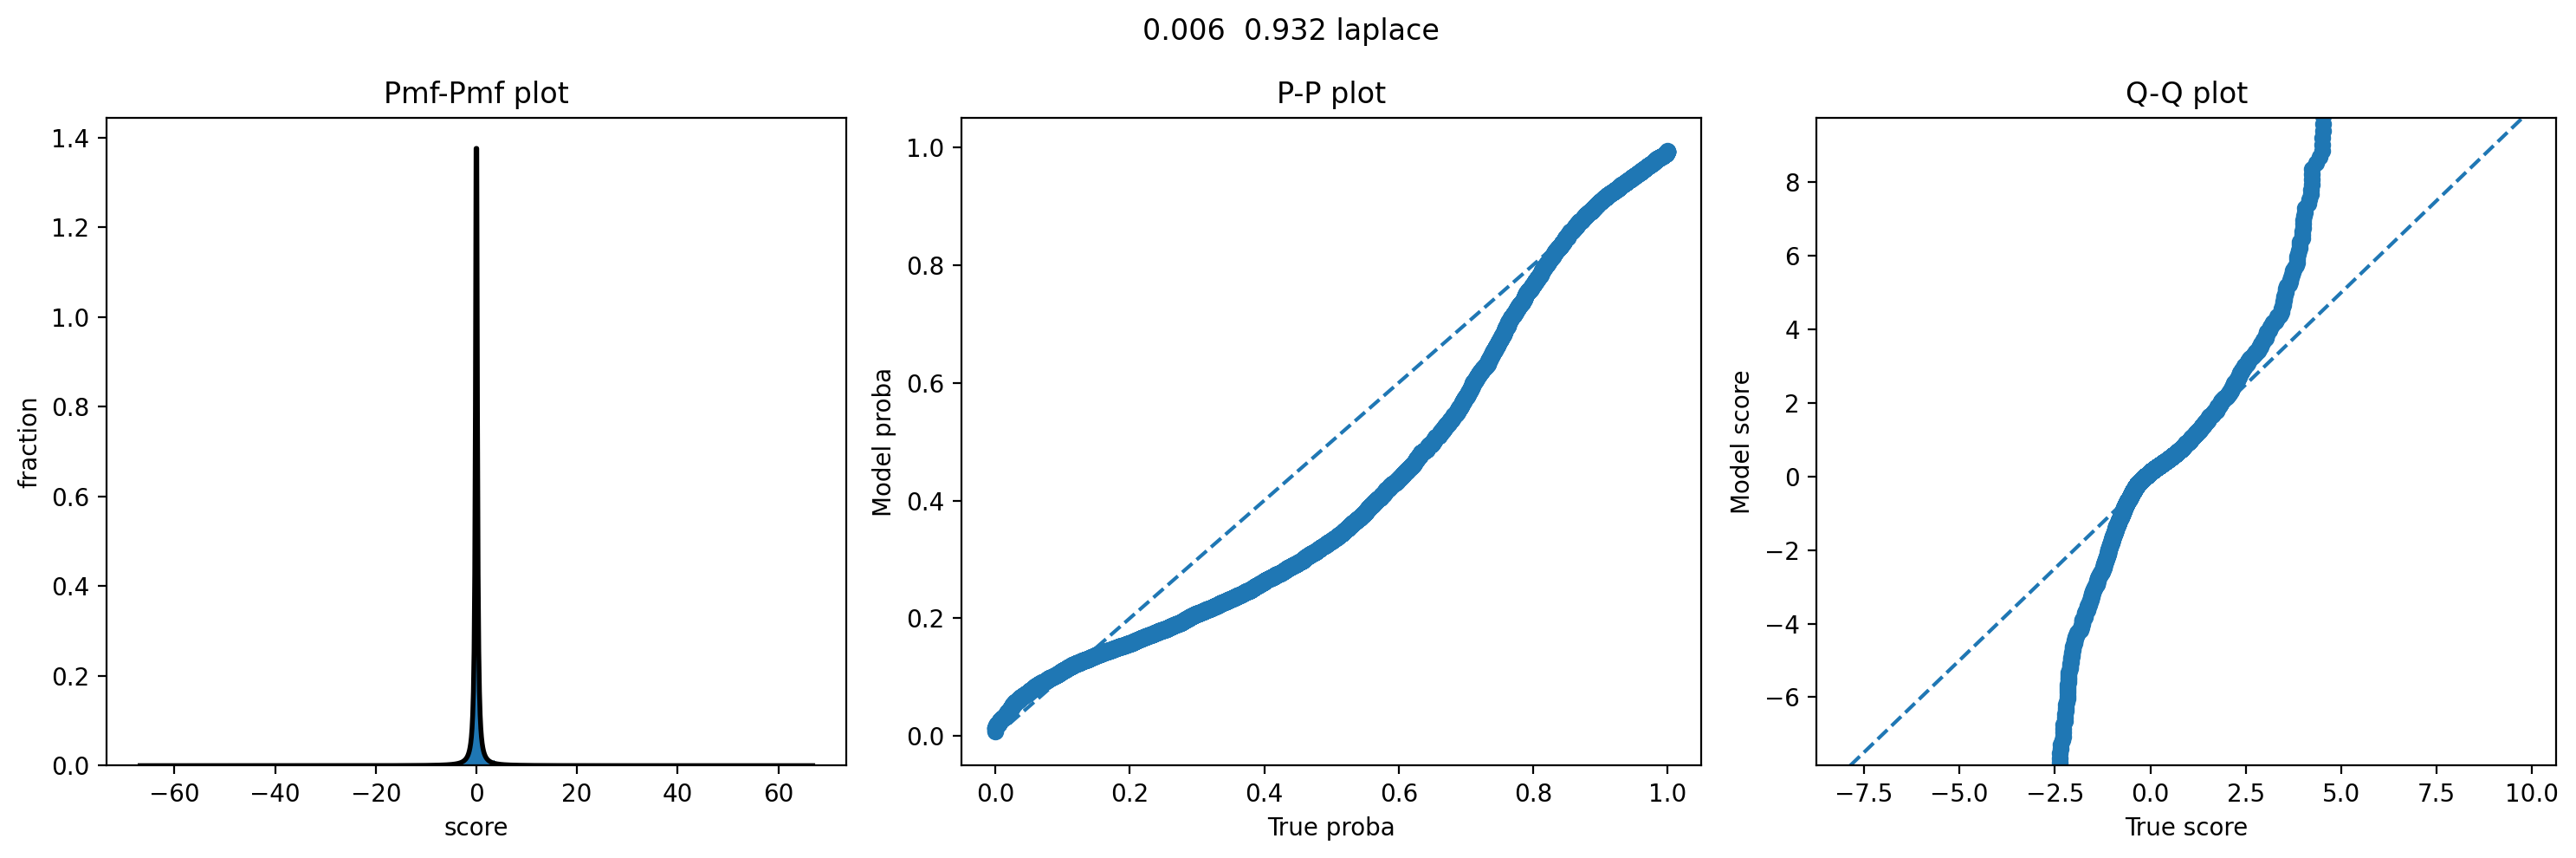

In [58]:
histo_plot_cauchy(0)

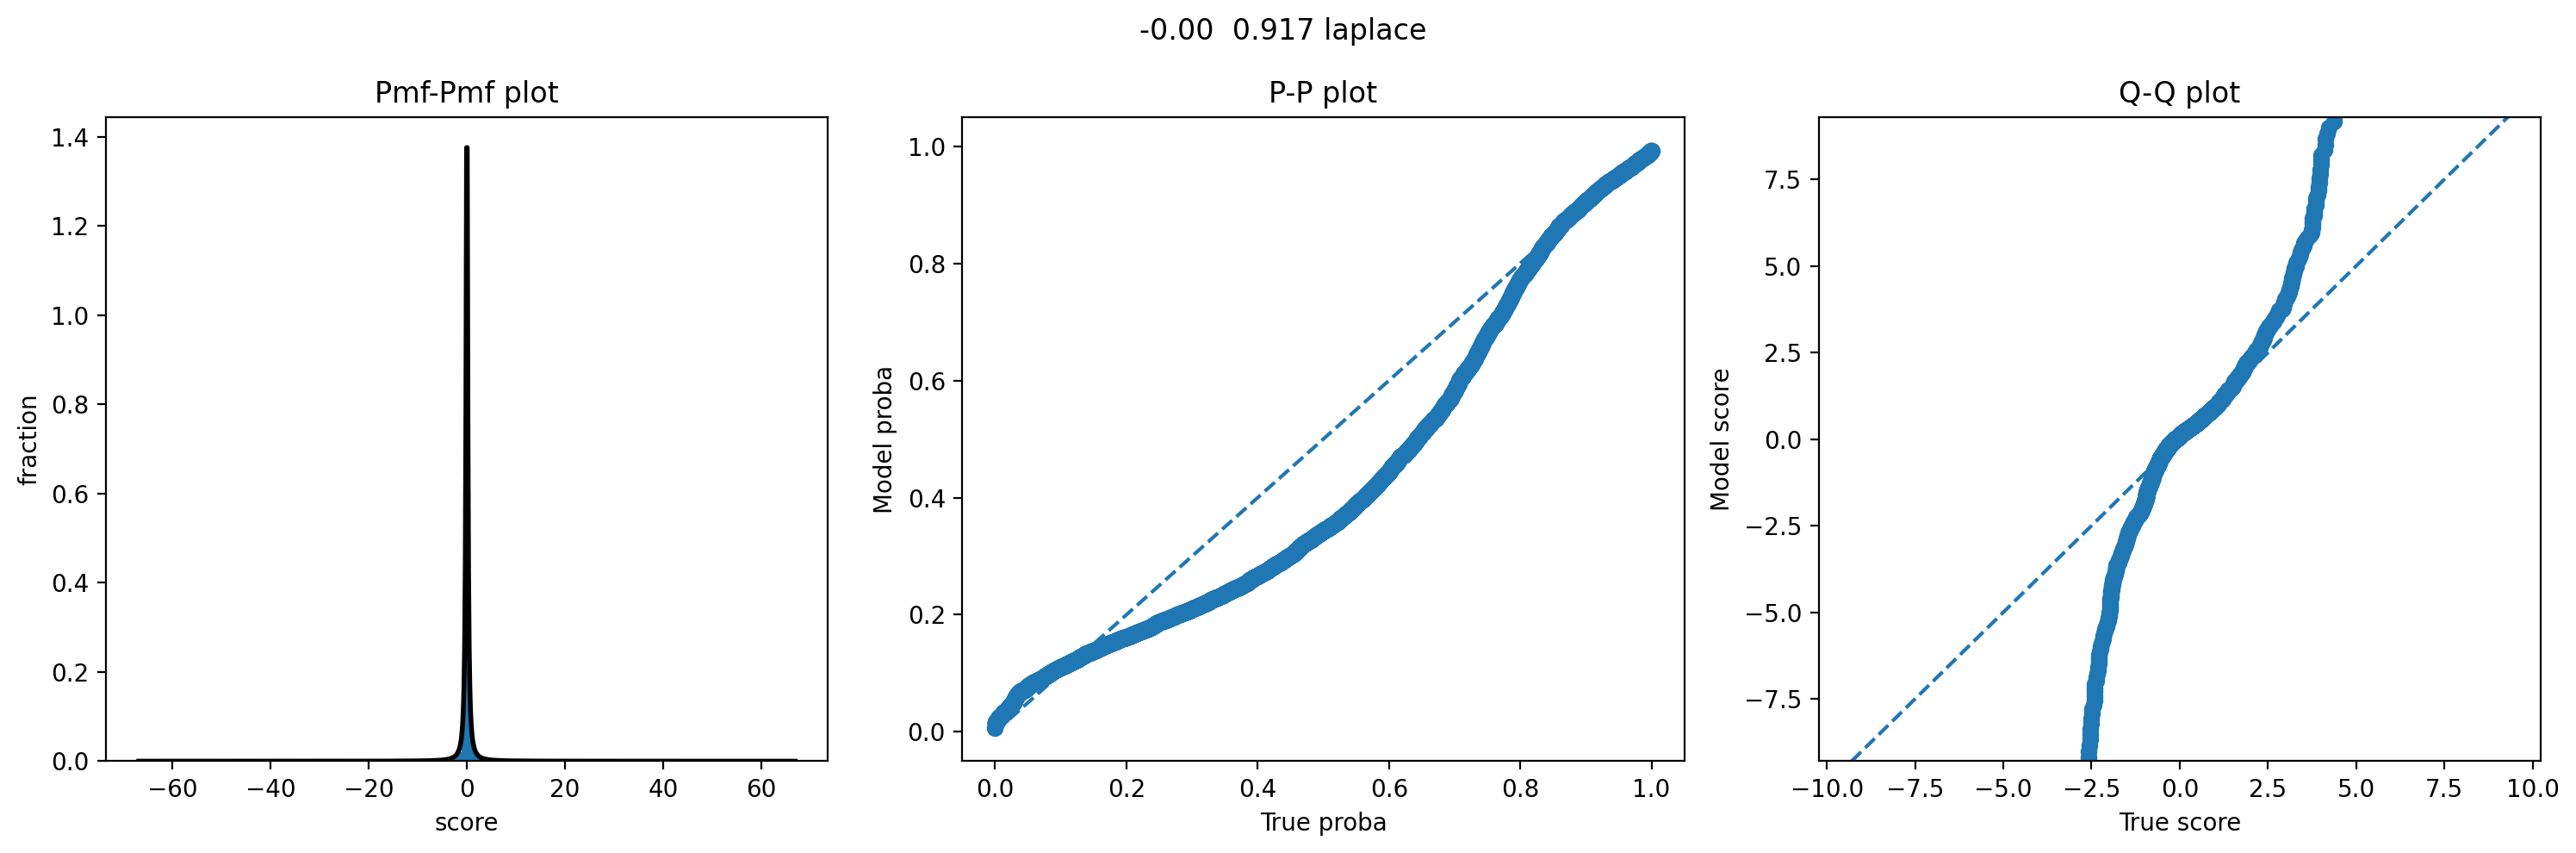

In [59]:
histo_plot_cauchy(100)

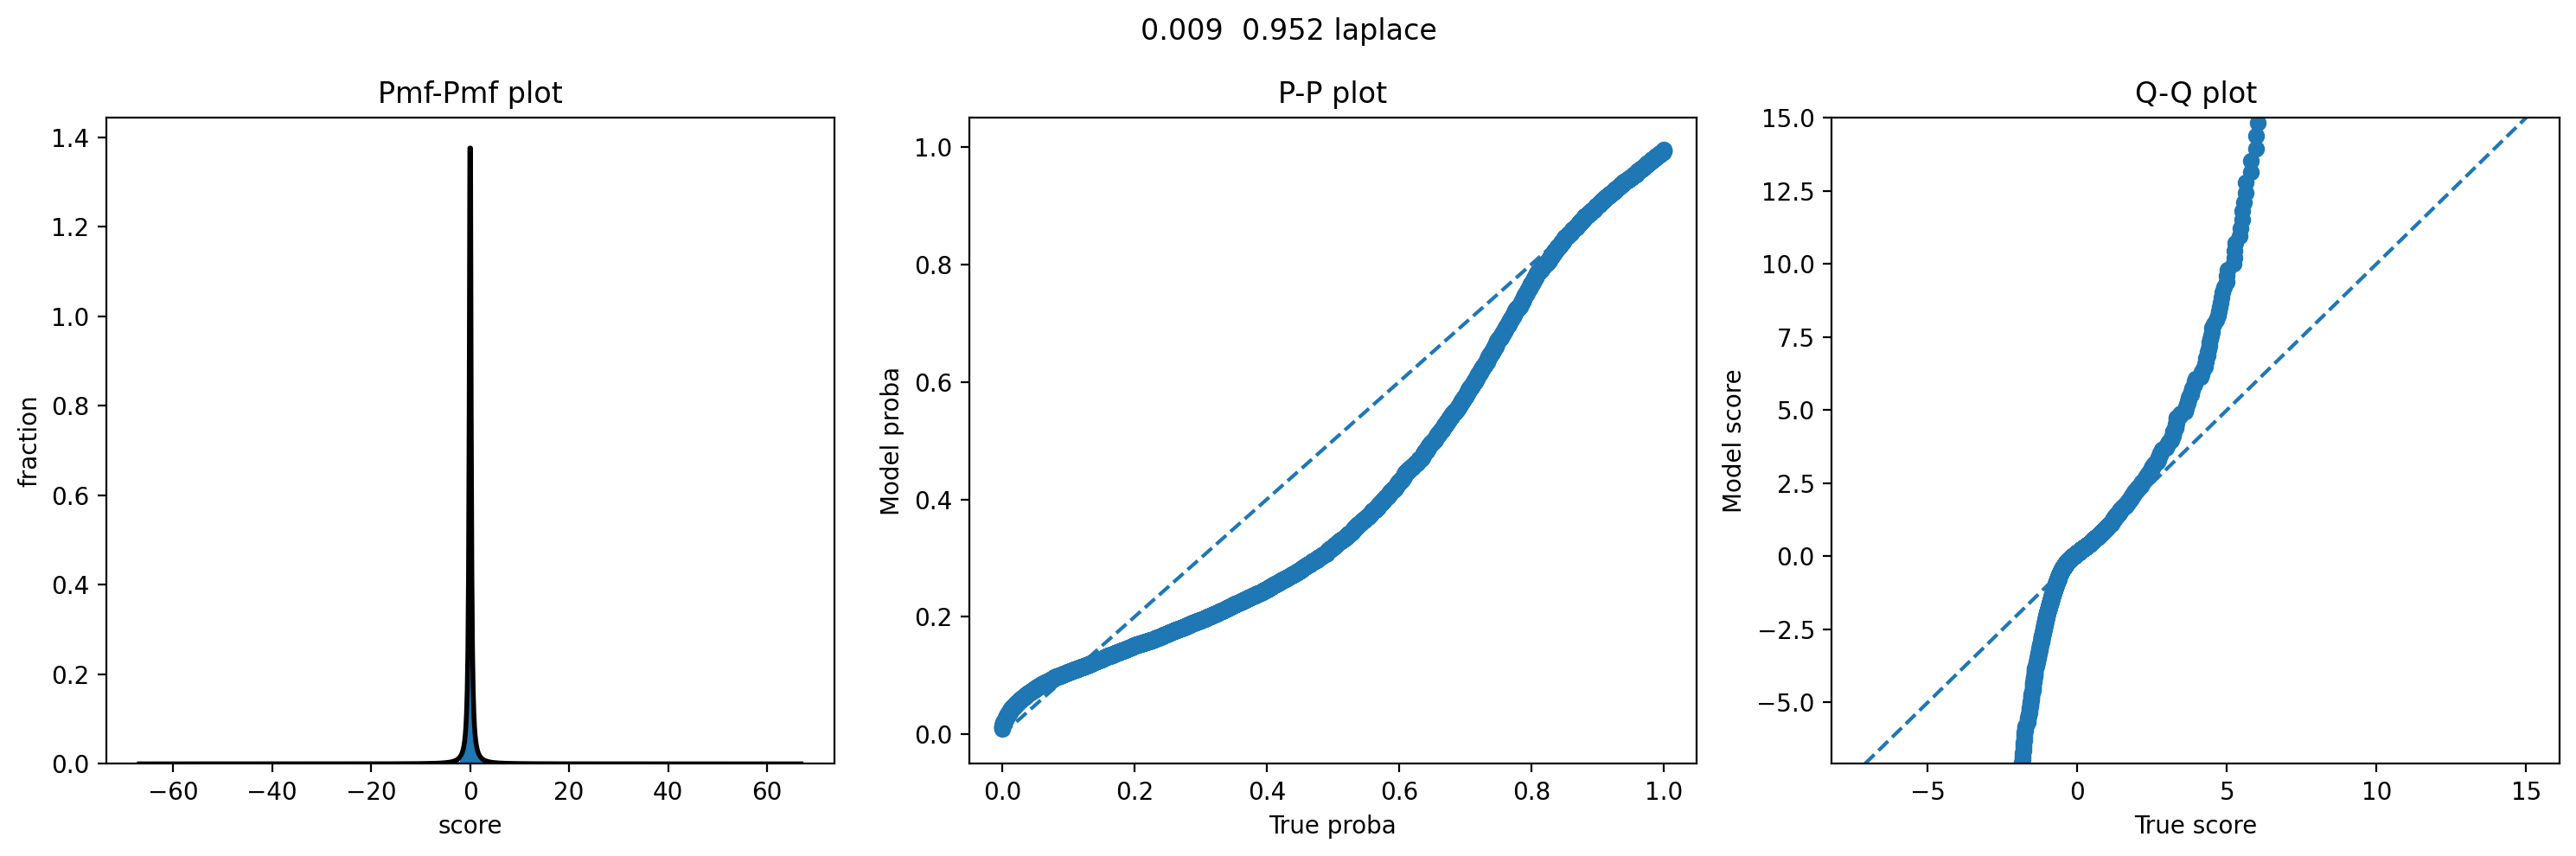

In [60]:
histo_plot_cauchy(1600)

In [94]:
def histo_plot_asym_laplace(i):
    fig,ax=plt.subplots(1,3,figsize=(15,5))
    lou=sorted(f_actual_data_array[:,i])
    m=np.mean(lou)
    std=np.std(lou)
    
    #rv = scipy.stats.laplace_asymmetric(kappa=0.8,loc=m-0.2,scale=std/3)
    kappa=0.99
    lamb=0.09**0.5
    loc=m+(kappa**2-1)/(lamb*kappa)
    rv = scipy.stats.laplace_asymmetric(kappa=kappa,loc=loc,scale=lamb)
    ax[0].hist(f_actual_data_array[:,i],100,density=True)
    x = np.linspace(rv.ppf(0.0001),
                rv.ppf(0.9999), 1000)
    ax[0].plot(x, rv.pdf(x), 'k-', lw=5)
    #ax[0].set_title(str(m)[:5]+'  '+str(std)[:5])
    
   
    ax[1].scatter(np.arange(0,1,1./len(lou)),[rv.cdf(h) for h in lou])
    ax[1].plot([0,1],[0,1],'--')
    
    ax[2].scatter(lou,[rv.ppf(h*1./len(lou)) for h in range(len(lou))])
    ax[2].plot(lou,lou,'--')
    
    
    ax[0].set_xlabel('score')
    ax[0].set_ylabel('fraction')
    
    ax[0].set_title('Pmf-Pmf plot')
    
    ax[1].set_xlabel('True proba')
    ax[1].set_ylabel('Model proba')
    
    ax[1].set_title('P-P plot')
    
    ax[2].set_xlabel('True score')
    ax[2].set_ylabel('Model score')
    ax[2].set_title('Q-Q plot')
    #plt.legend(loc='best')
    #plt.title(v[0])
    fig.suptitle(str(m)[:5]+'  '+str(std)[:5]+' laplace')
    plt.tight_layout()
    plt.show()

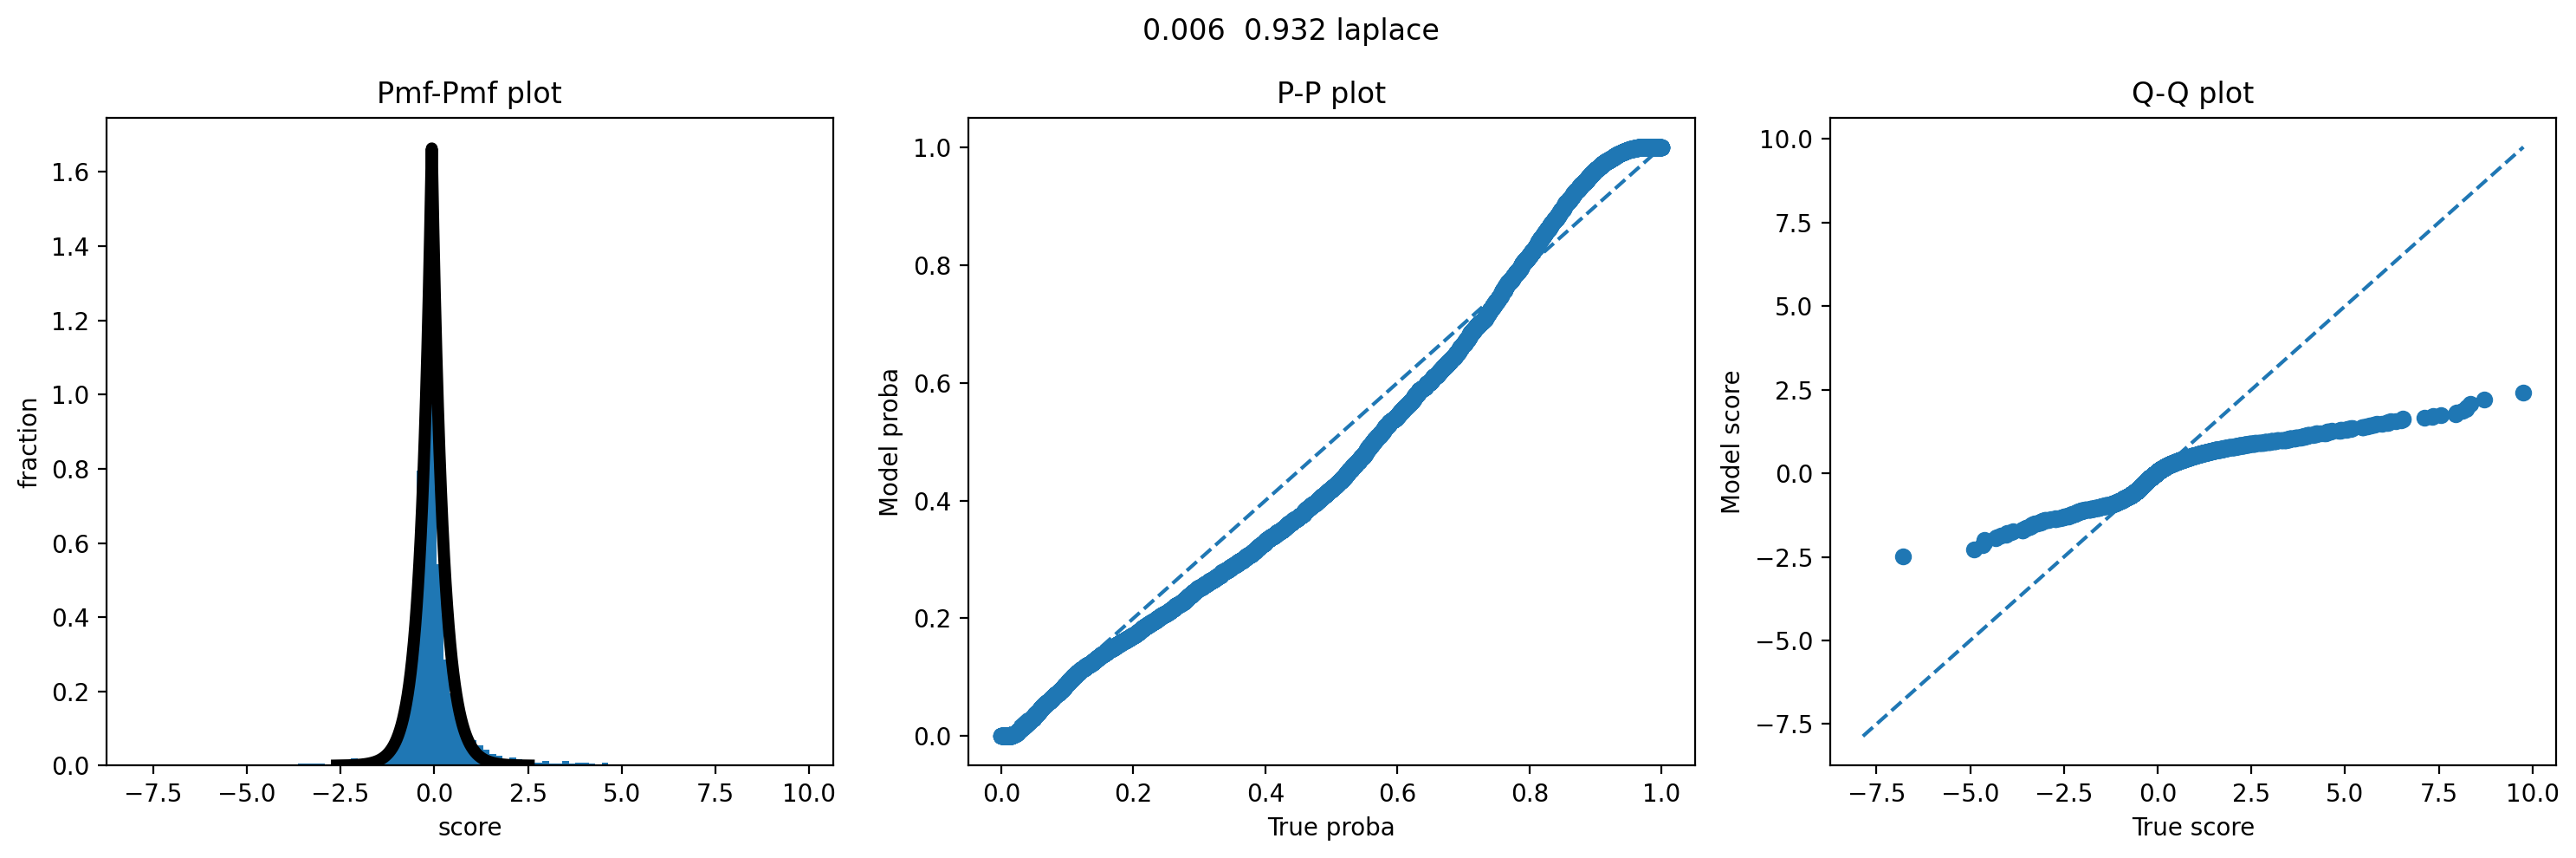

In [91]:
histo_plot_asym_laplace(0)

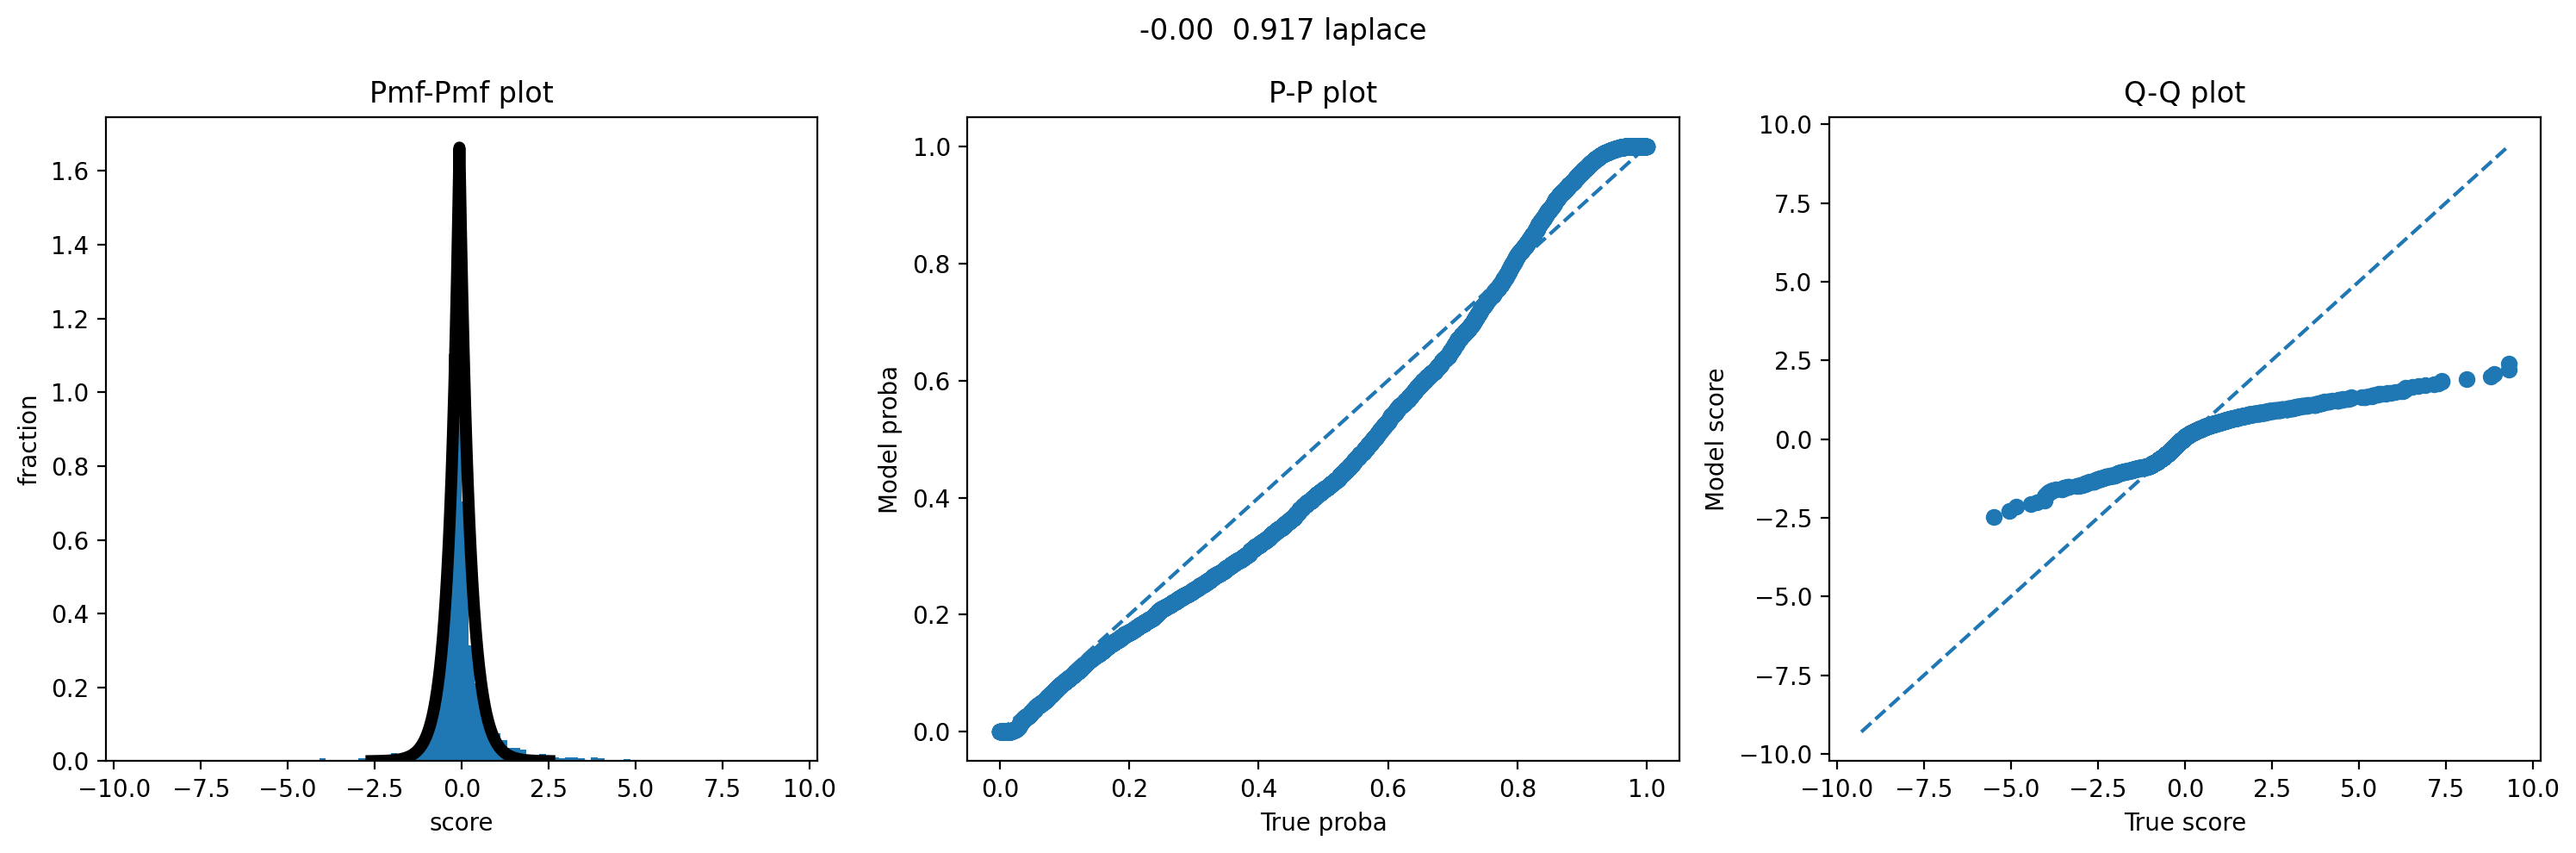

In [92]:
histo_plot_asym_laplace(100)

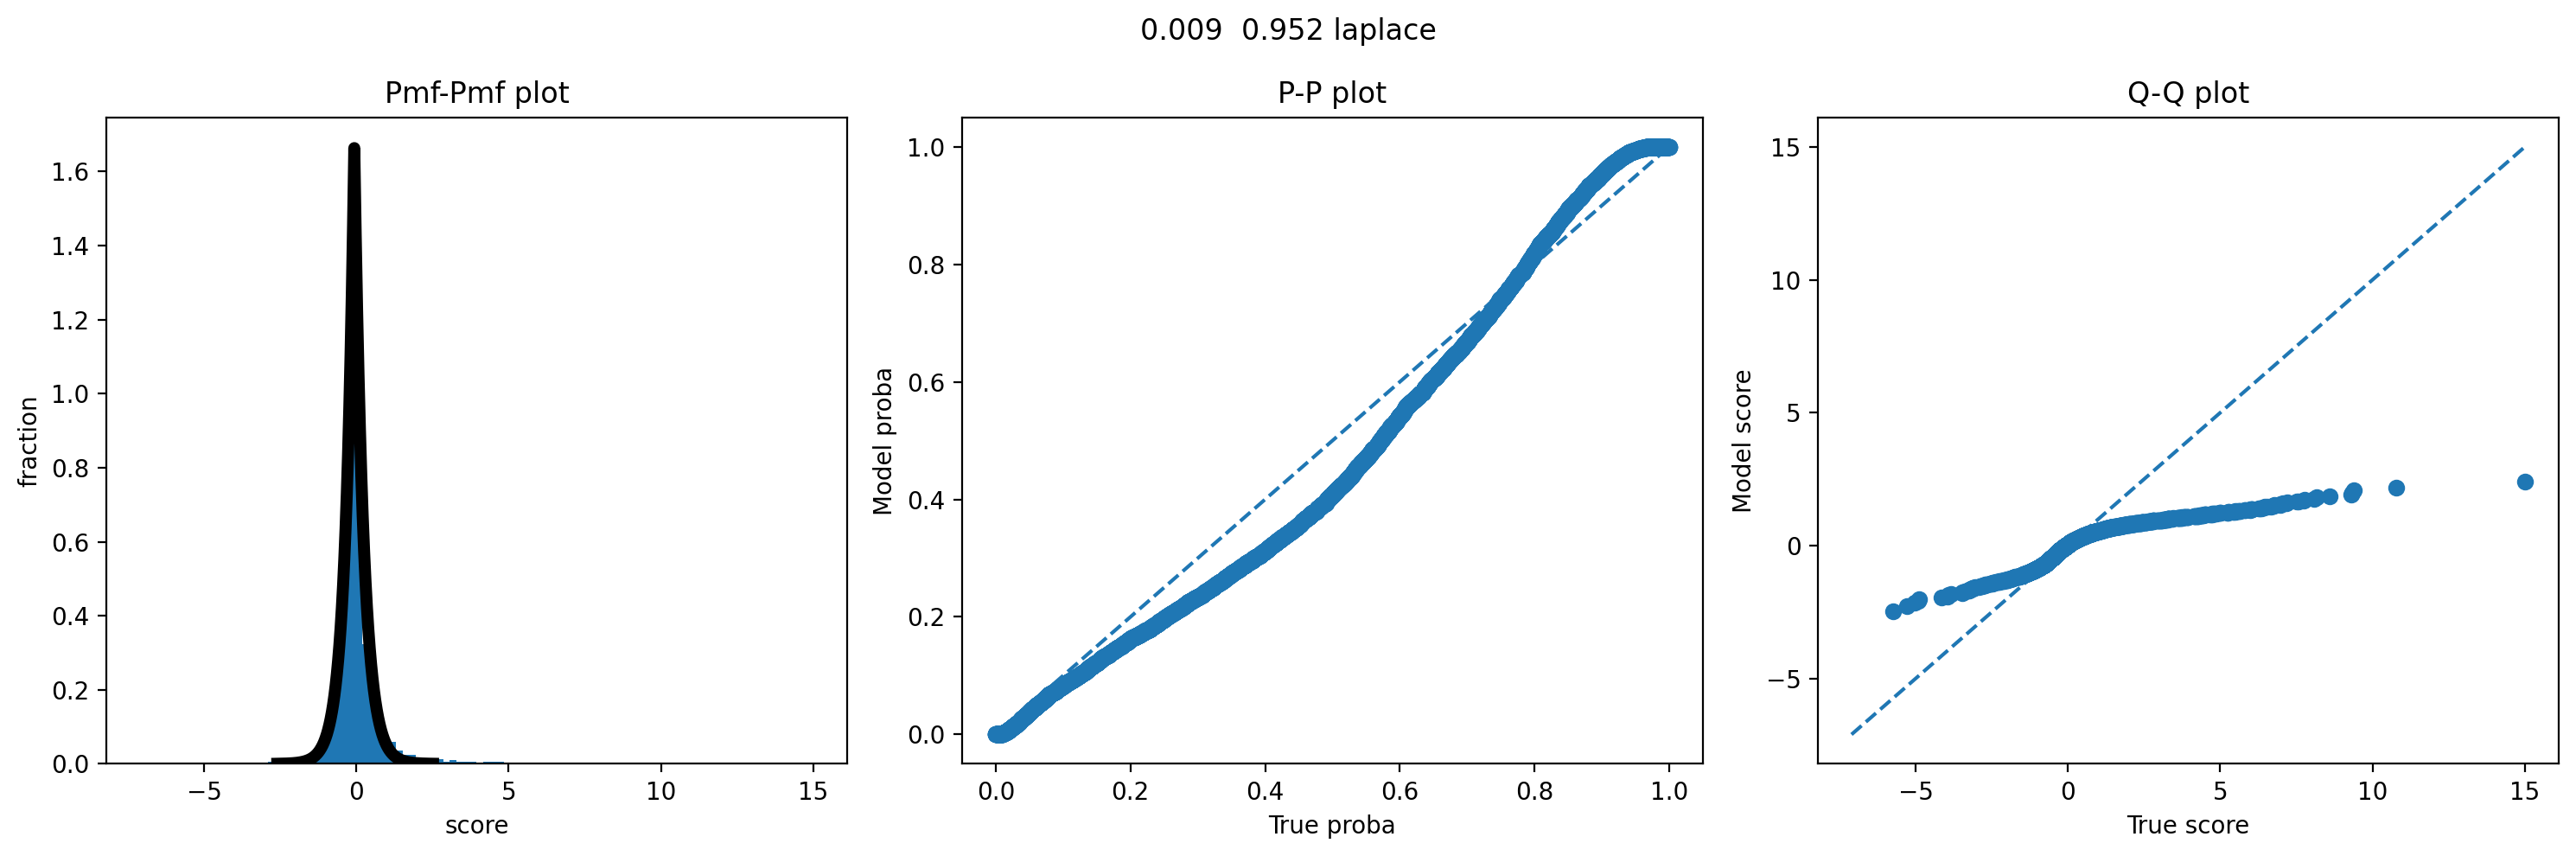

In [93]:
histo_plot_asym_laplace(1600)